<a href="https://colab.research.google.com/github/strugglepanda/2dses/blob/main/WeChatMsgAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 微信聊天记录分析 WeChatMsgAnalysis
依照 [WeChatMsg](https://github.com/LC044/WeChatMsg) 的教程导出 `csv` 文件，只需要导出文本即可。

点击左侧的文件，上传 `csv` 文件并且重命名为 `msg.csv`。

In [152]:
!pip install numpy seaborn pandas wordcloud tqdm paddlepaddle paddlenlp

## 准备阶段
### 引入包
* pandas: 基础数据框架
* matplotlib & seaborn: 主要绘图框架
* jieba: 中文分词
* wordcloud: 词云
* paddlenlp: 情感分析

In [153]:
import re
import time
import numpy as np
import pandas as pd
import jieba
import jieba.posseg as pseg
from PIL import Image
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.ticker as mticker
import matplotlib.transforms as mtransforms
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
from tqdm import tqdm
from paddlenlp import Taskflow

### 绘图设置

In [198]:
sns.set_theme(style="ticks")
font = "wqy-zenhei.ttc"
fp = fm.FontProperties(fname=font)
plt.rcParams["axes.unicode_minus"] = False

### 人名标签

In [155]:
labels = ["ZT", "DCL"]

### 数据读取
* `filePath`: 消息记录文件的路径
* `dStart`: 开始的时间
* `dEnd`: 结束的时间
* `tZone`: 时区，例如北京时间为 `+8`

In [156]:
filePath = "msg.csv"
dStart = "2023-01-01 00:00:00 +0800"
dEnd = "2023-12-31 23:59:59 +0800"
tZone = 8

In [157]:
df = pd.read_csv(filePath, encoding="utf-8")

df = df.query(
    "CreateTime >= {:d} and CreateTime <= {:d}".format(
        int(time.mktime(time.strptime(dStart, "%Y-%m-%d %H:%M:%S %z"))) - 3600 * tZone,
        int(time.mktime(time.strptime(dEnd, "%Y-%m-%d %H:%M:%S %z"))) - 3600 * tZone,
    )
)

df.loc[:, "StrTime"] = pd.to_datetime(df["StrTime"])
df.loc[:, "day"] = df["StrTime"].dt.dayofweek
df.loc[:, "hour"] = df["StrTime"].dt.hour
df.loc[:, "Count"] = 1

dfs = [df.query("IsSender == 0"), df.query("IsSender == 1")]

### 消息过滤

In [158]:
def textFilter(text: str):
    text = text.lower()
    # try:
    #     co = re.compile("[\U00010000-\U0010ffff]")
    # except re.error:
    #     co = re.compile("[\uD800-\uDBFF][\uDC00-\uDFFF]")
    # text = co.sub(" ", text)
    co = re.compile("\[[\u4e00-\u9fa5]+\]")
    return co.sub(" ", text)

### 获取文本消息

In [159]:
texts = [
    [textFilter(i) for i in dfs[0].query("Type == 1")["StrContent"].to_list()],
    [textFilter(i) for i in dfs[1].query("Type == 1")["StrContent"].to_list()],
]

## 消息频率分析
### 类型分析
根据消息的类型进行分类，可以看出喜欢发送的消息类型，同时也可以看出谁发的多
* 1 = Text
* 3 = Image
* 34 = Voice
* 43 = Video
* 47 = Sticker
* 48 = Location
* 10000 = System

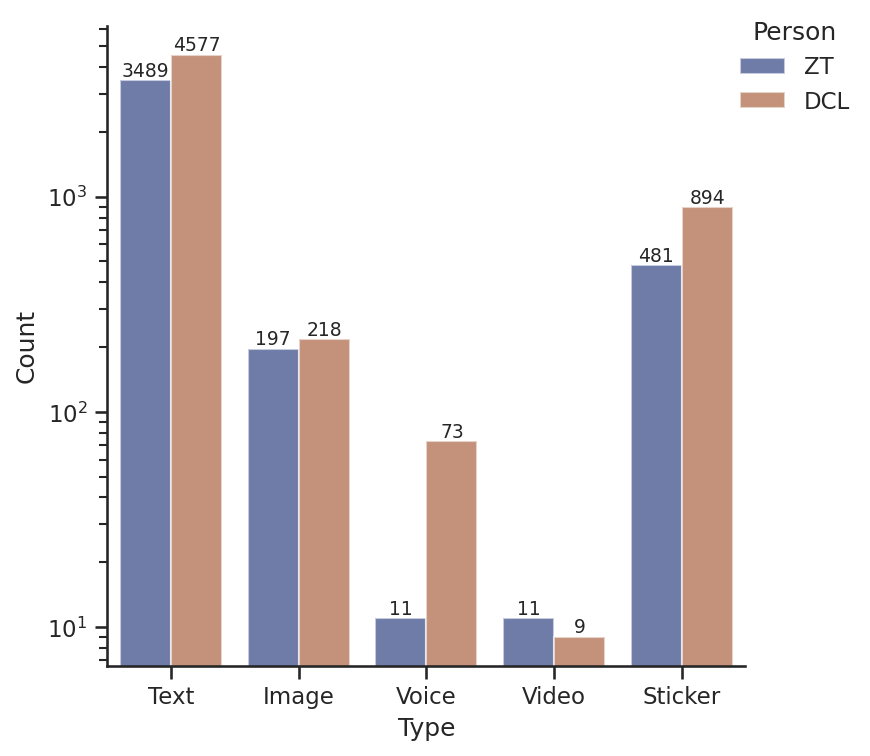

In [160]:
data = {}
for i in range(2):
    data[labels[i]] = [
        len(dfs[i].query("Type == 1")),
        len(dfs[i].query("Type == 3")),
        len(dfs[i].query("Type == 34")),
        len(dfs[i].query("Type == 43")),
        len(dfs[i].query("Type == 47")),
    ]

data = (
    pd.DataFrame(data, index=["Text", "Image", "Voice", "Video", "Sticker"])
    .reset_index()
    .melt("index")
    .rename(columns={"index": "Type", "variable": "Person", "value": "Count"})
)
g = sns.catplot(data, kind="bar", x="Type", y="Count", hue="Person", palette="dark", alpha=0.6, height=6)

for ax in g.axes.ravel():
    for i in range(2):
        ax.bar_label(ax.containers[i], fontsize=9)
sns.move_legend(g, "upper right")
plt.yscale("log")

g.figure.set_size_inches(6, 5)
g.figure.set_dpi(150)
plt.show()
plt.close()

### 消息长度分析
* `sN`: 设置显示范围：
$$
\mu + \mathrm{sN} * \sigma
$$
* `multiple`: 直方图堆叠格式

In [161]:
sN = 3
multiple = "dodge"

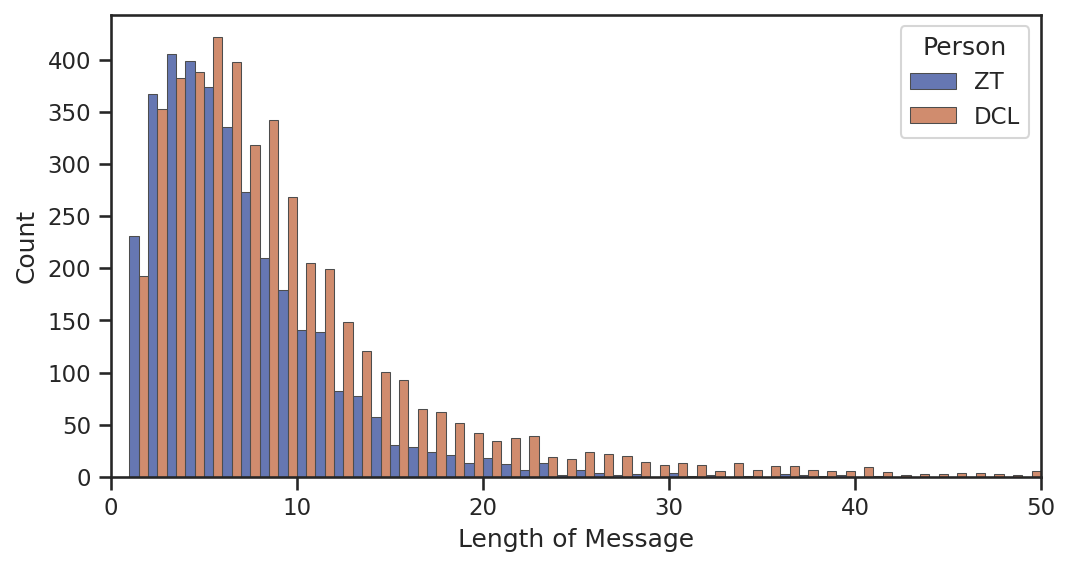

In [162]:
mu, std = 0, 0
data = {"Length": [], "Person": []}
for i in range(2):
    length = [len(textFilter(i)) for i in texts[i]]
    data["Length"] += length
    data["Person"] += [labels[i]] * len(length)
    if np.mean(length) + sN * np.std(length) > mu + std:
        mu, std = np.mean(length), np.std(length)
xlim = int(np.ceil(mu + sN * std))

data = pd.DataFrame(data)
bins = np.linspace(0, xlim, xlim + 1)

ax = sns.histplot(
    data=data,
    x="Length",
    hue="Person",
    bins=bins,
    multiple=multiple,
    edgecolor=".3",
    linewidth=0.5,
    palette="dark",
    alpha=0.6,
)
ax.set_xlim(0, xlim)
ax.set_xlabel("Length of Message")

ax.figure.set_size_inches(8, 4)
ax.figure.set_dpi(150)
plt.show()
plt.close()

### 每日活跃分析
划分每日24小时内每小时发送的消息数，可以得知每天的活跃的时间段

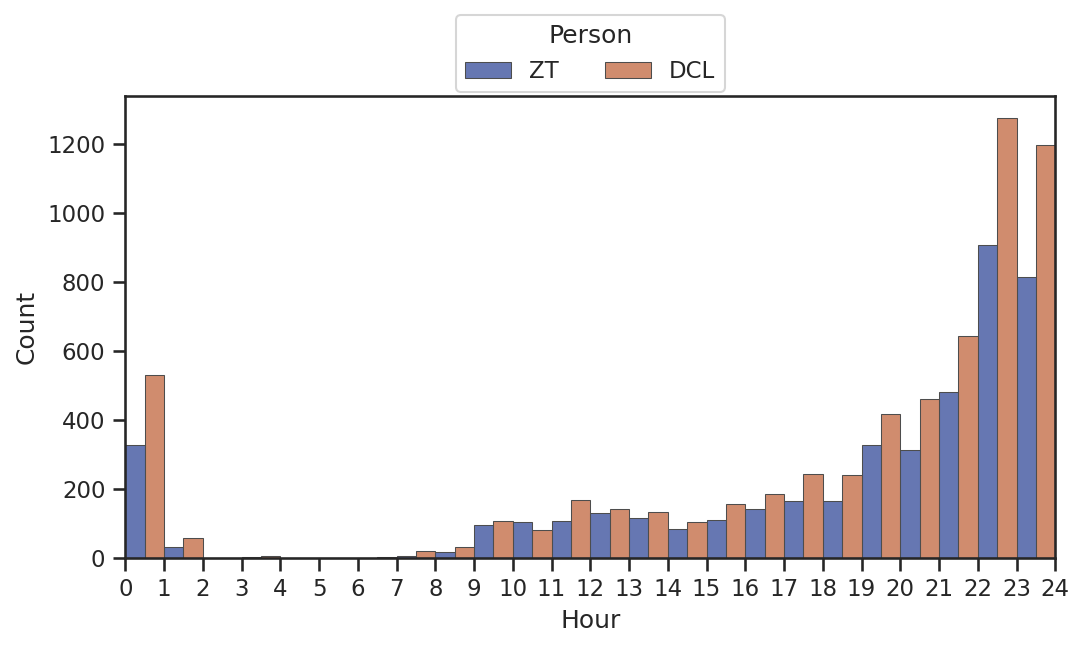

In [163]:
data = {"Time": [], "Person": []}
for i in range(2):
    hour = dfs[i]["hour"].to_list()
    data["Time"] += hour
    data["Person"] += [labels[i]] * len(hour)

data = pd.DataFrame(data)
bins = np.arange(0, 25, 1)

ax = sns.histplot(
    data=data,
    x="Time",
    hue="Person",
    bins=bins,
    multiple=multiple,
    edgecolor=".3",
    linewidth=0.5,
    palette="dark",
    alpha=0.6,
)
ax.set_xticks(bins)
ax.set_xticklabels(bins)
ax.set_xlabel("Hour")
ax.set_xlim(0, 24)
sns.move_legend(ax, loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)

ax.figure.set_size_inches(8, 4)
ax.figure.set_dpi(150)
plt.show()
plt.close()

### 每周活跃分析
查看一周内从周一到周日每天发送的消息数

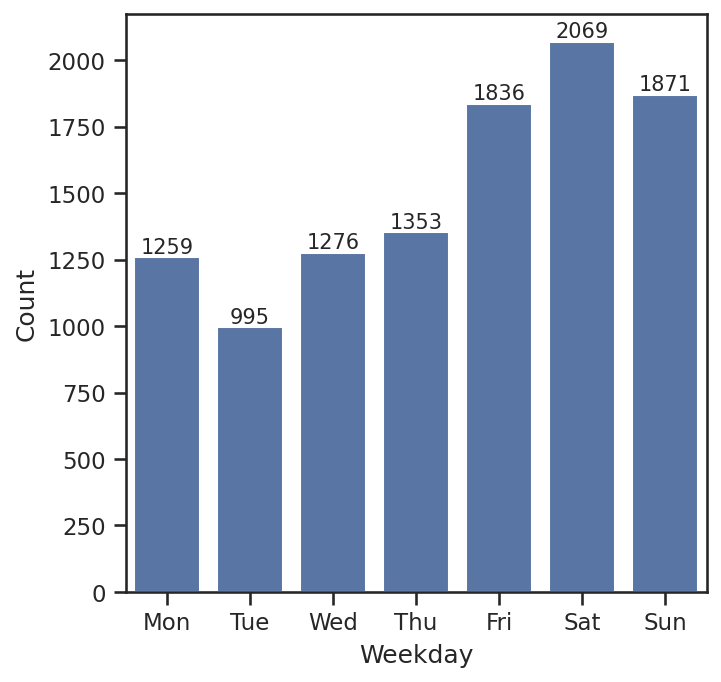

In [164]:
grouper = pd.Grouper(key="day")
data = df.groupby(grouper)["Count"].sum()
data = data.sort_index()
data.index = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

ax = sns.barplot(data=data, errorbar=None)
ax.set_xlabel("Weekday")
ax.bar_label(ax.containers[0], fontsize=10)

ax.figure.set_size_inches(5, 5)
ax.figure.set_dpi(150)
plt.show()
plt.close()

### 按周划分年度活跃分析
划分每7天内发送的消息数，可以得知每周的活跃的时间段
* `wTicks`: 每个刻度相差的数值
* `wStart`: **当年**第一个周一的日期
* `wEnd`: **次年**第一个周一的日期

In [165]:
wTicks = 500
wStart = "2023-01-02"
wEnd = "2024-01-01"

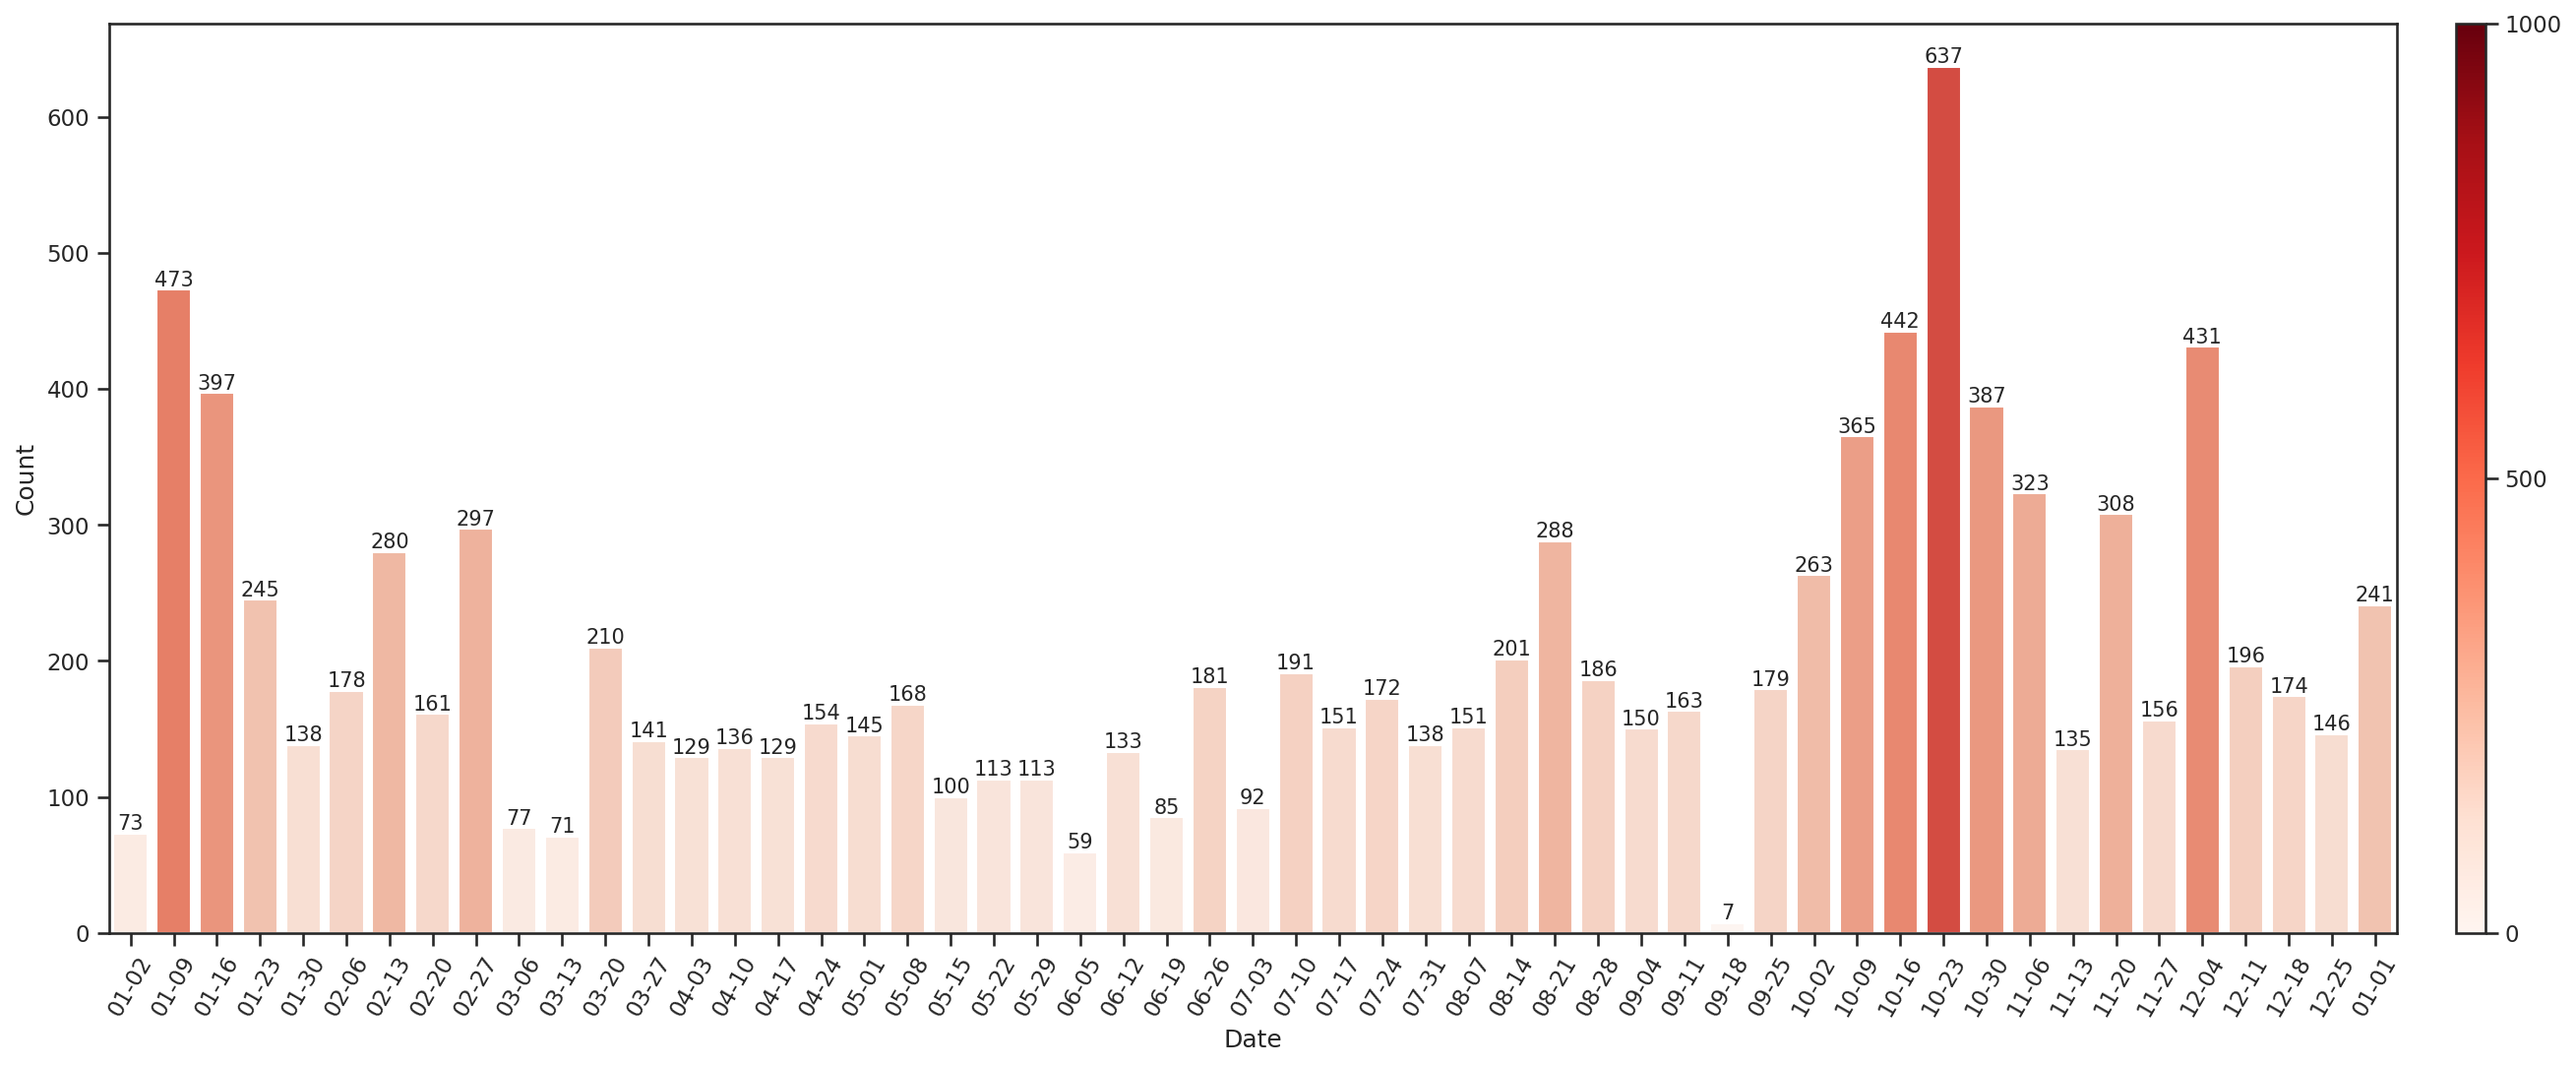

In [166]:
grouper = pd.Grouper(key="StrTime", freq="W-MON")
data = df.groupby(grouper)["Count"].sum().to_frame()
data.index = pd.date_range(start=wStart, end=wEnd, freq="W-MON").strftime("%m-%d")
data.columns = ["Count"]

vM = np.ceil(data["Count"].max() / wTicks) * wTicks
norm = plt.Normalize(0, vM)
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)

ax = sns.barplot(x=data.index, y=data["Count"], hue=data["Count"], hue_norm=norm, palette="Reds")
ax.set_xlabel("Date")
plt.xticks(rotation=60)
for bar in ax.containers:
    ax.bar_label(bar, fontsize=10, fmt="%.0f")
ax.get_legend().remove()

axpos = ax.get_position()
caxpos = mtransforms.Bbox.from_extents(axpos.x1 + 0.02, axpos.y0, axpos.x1 + 0.03, axpos.y1)
cax = ax.figure.add_axes(caxpos)

locator = mticker.MultipleLocator(wTicks)
formatter = mticker.StrMethodFormatter("{x:.0f}")
cax.figure.colorbar(sm, cax=cax, ticks=locator, format=formatter)

ax.figure.set_size_inches(20, 8)
ax.figure.set_dpi(150)
plt.show()
plt.close()

### 按周划分聊天热情分析
划分每7天内的聊天热情指数，聊天热情指数为发送的消息数减去收到的消息数与总消息数的比值：
$$
E = \frac{Q_\mathrm{S} - Q_\mathrm{R}}{Q_\mathrm{S} + Q_\mathrm{R}}
$$

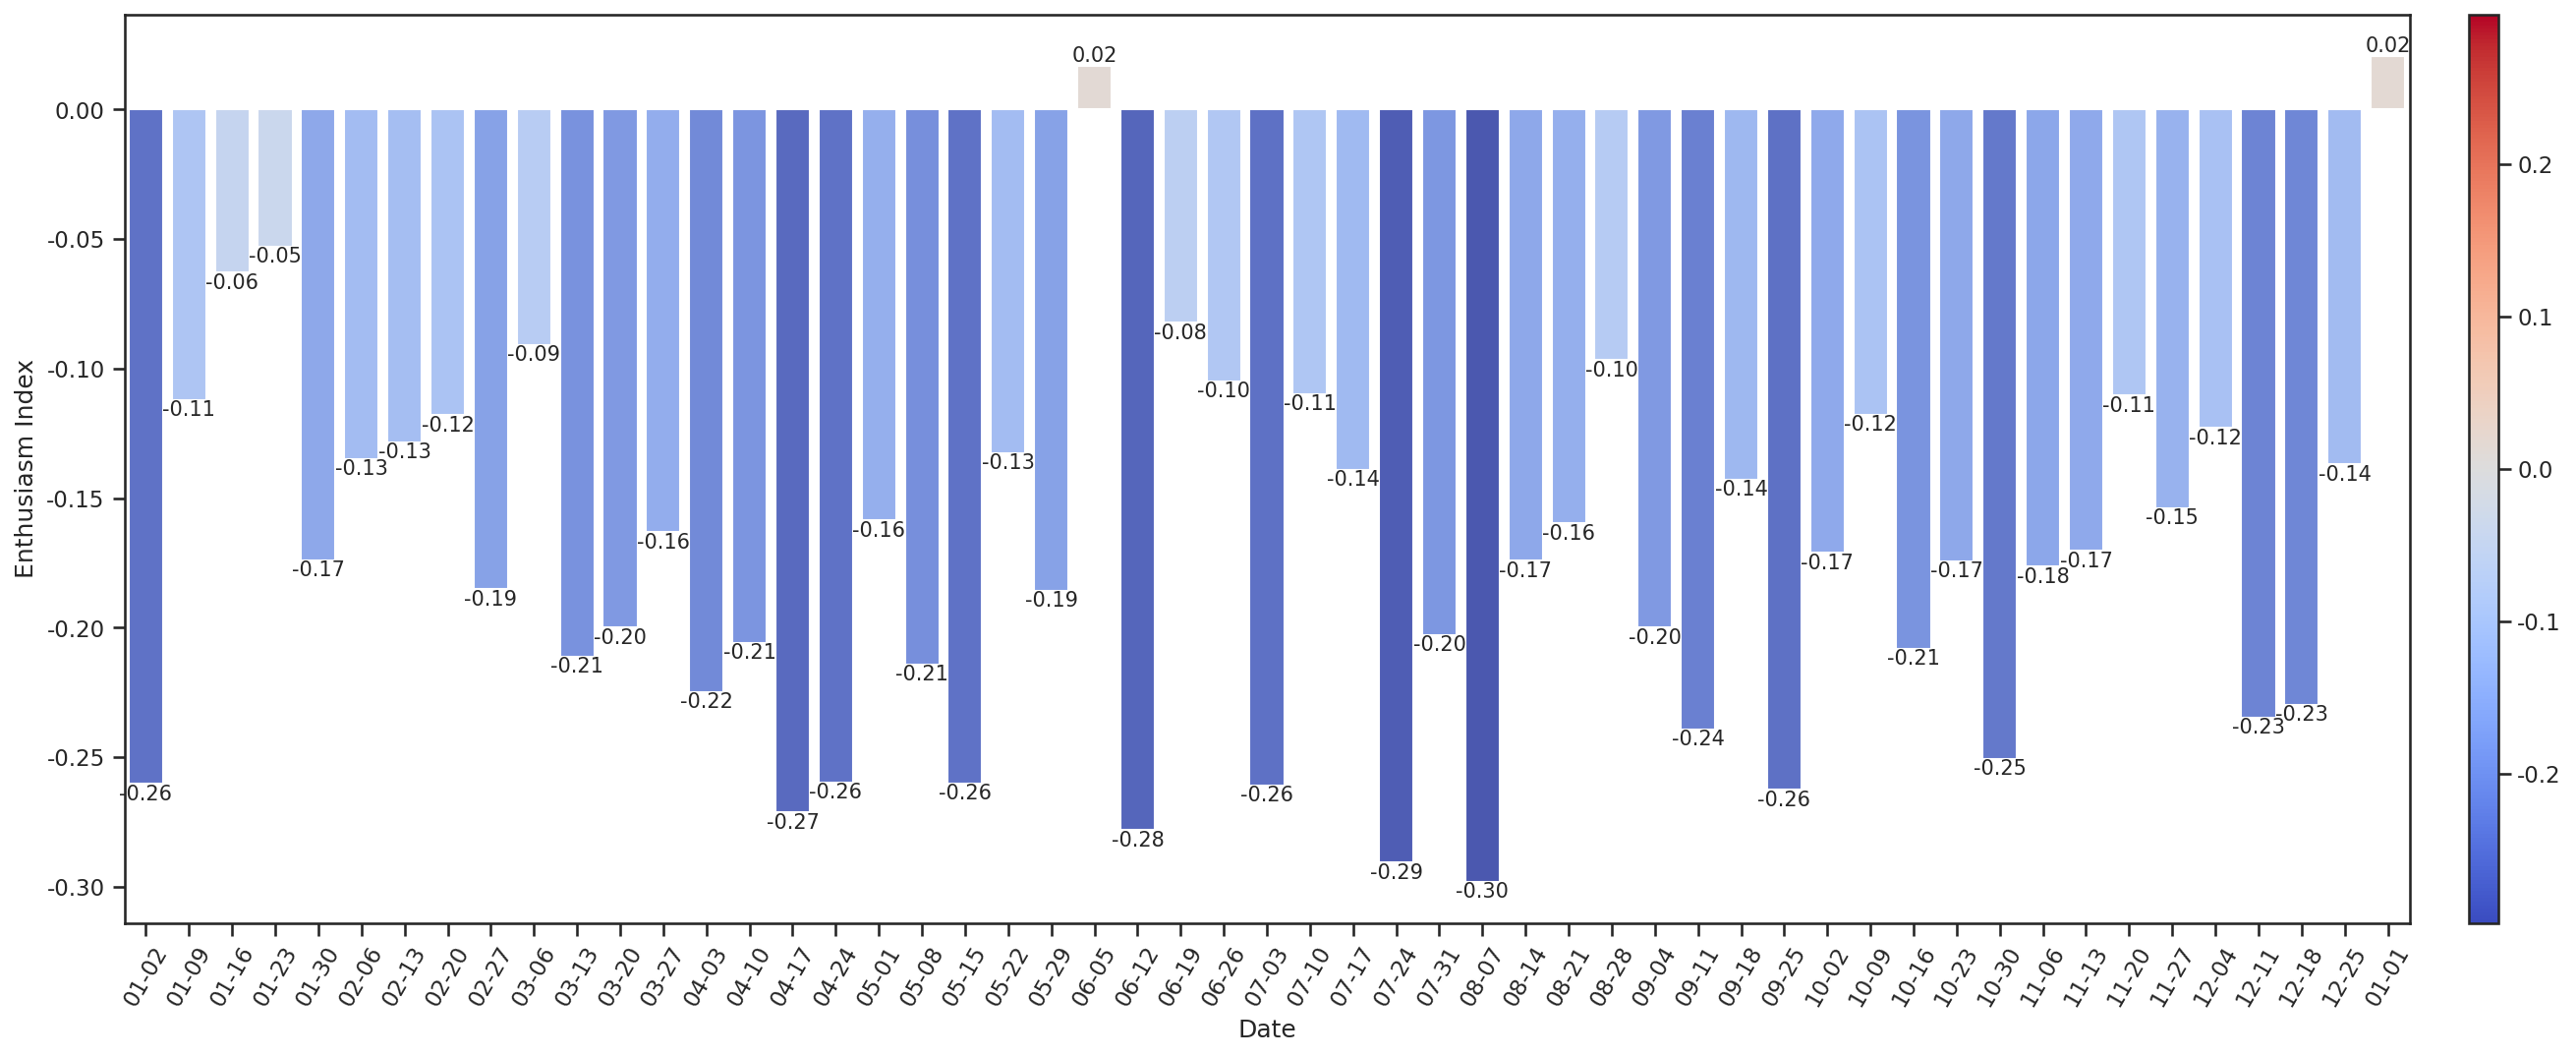

In [167]:
grouper = pd.Grouper(key="StrTime", freq="W-MON")
df_W1 = dfs[0].groupby(grouper)["Count"].sum()
df_W2 = dfs[1].groupby(grouper)["Count"].sum()

data = pd.DataFrame({"E": (df_W1 - df_W2) / (df_W1 + df_W2)})
data.index = pd.date_range(start=wStart, end=wEnd, freq="W-MON").strftime("%m-%d")

vM = data["E"].abs().max()
norm = plt.Normalize(-vM, vM)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)

ax = sns.barplot(x=data.index, y=data["E"], hue=data["E"], hue_norm=norm, palette="coolwarm")
ax.set_xlabel("Date")
plt.xticks(rotation=60)
ax.set_ylabel("Enthusiasm Index")
for bar in ax.containers:
    ax.bar_label(bar, fontsize=10, fmt="%.2f")
ax.get_legend().remove()

axpos = ax.get_position()
caxpos = mtransforms.Bbox.from_extents(axpos.x1 + 0.02, axpos.y0, axpos.x1 + 0.03, axpos.y1)
cax = ax.figure.add_axes(caxpos)

locator = mticker.MultipleLocator(0.1)
formatter = mticker.StrMethodFormatter("{x:.1f}")
cax.figure.colorbar(sm, cax=cax, ticks=locator, format=formatter)

ax.figure.set_size_inches(20, 8)
ax.figure.set_dpi(150)
plt.show()
plt.close()

### 按日划分年度活跃分析
以热力图的方式展示按日划分的年度活跃情况

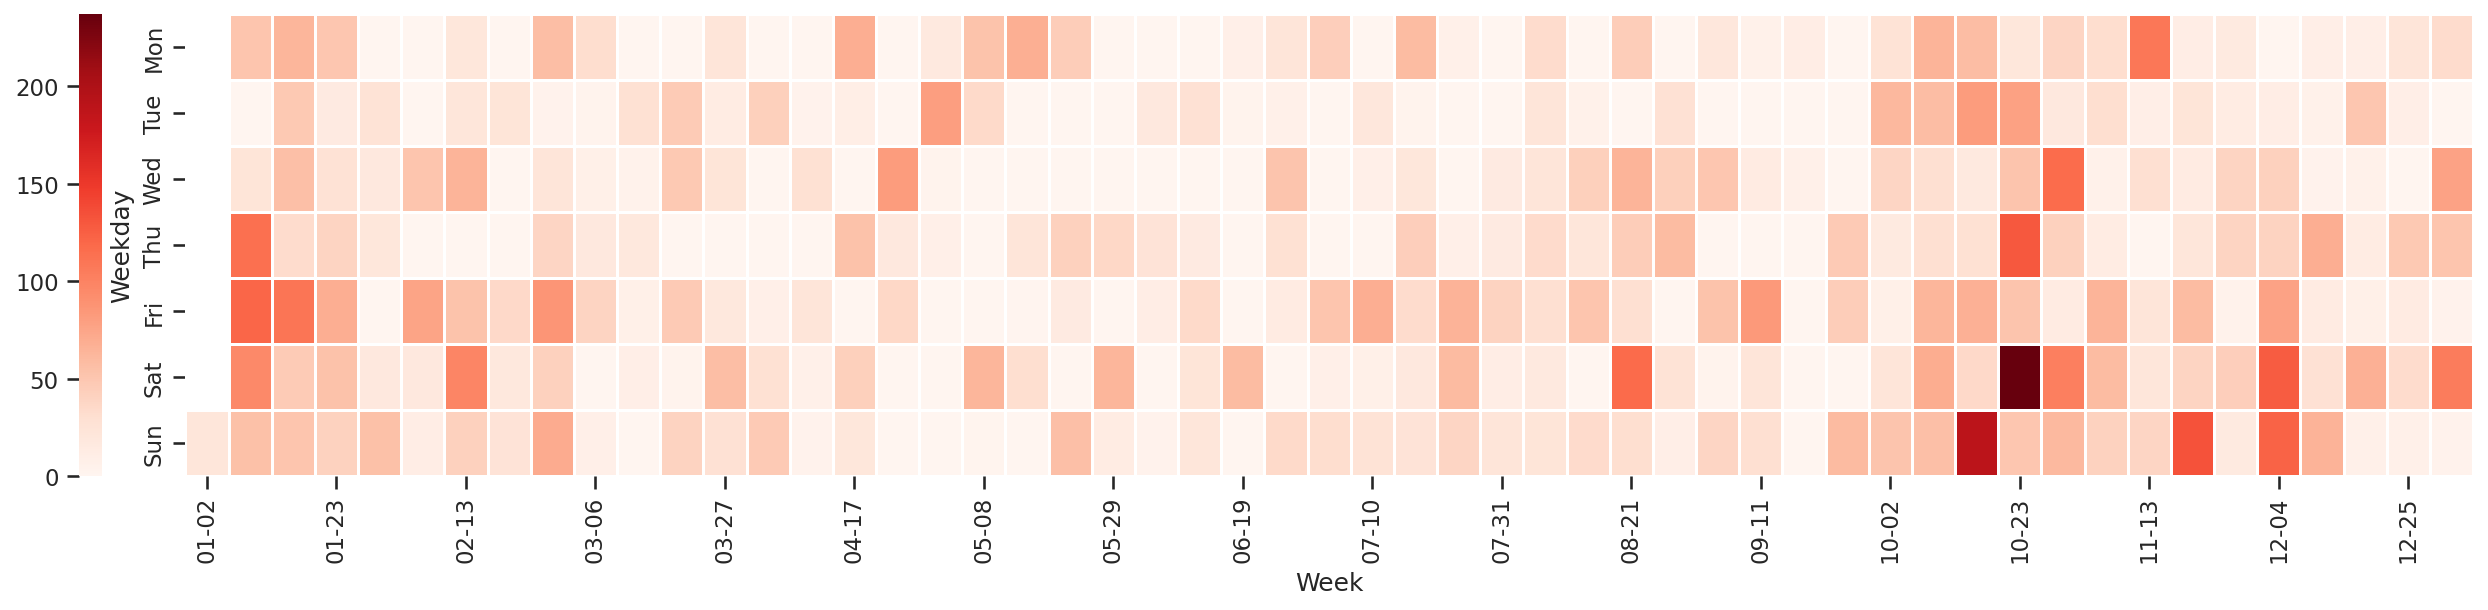

In [168]:
grouper = pd.Grouper(key="StrTime", freq="D")
data = df.groupby(grouper)["Count"].sum()
data = data.to_frame()

data["date"] = data.index
data["week"] = data["date"].dt.isocalendar()["week"]
data["day"] = data["date"].dt.dayofweek
data.index = range(len(data))
for i in range(7):
    if data.loc[i, "week"] > 1:
        data.loc[i, "week"] = 0

data = data.pivot(index="day", columns="week", values="Count")
data.index = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
data.columns = pd.date_range(start=wStart, end=wEnd, freq="W-MON").strftime("%m-%d")

ax = sns.heatmap(
    data,
    annot=False,
    linewidths=0.5,
    cbar_kws={"orientation": "vertical", "location": "left", "pad": 0.03},
    cmap="Reds",
)
ax.set_xlabel("Week")
ax.set_ylabel("Weekday")
ax.figure.set_size_inches(24, 4)
ax.figure.set_dpi(150)
plt.show()
plt.close()

## 词语分析
### 分词词典、停止词与去除词性

In [169]:
#jieba.load_userdict("thuocl.txt")
#jieba.load_userdict("userdict.txt")
stopwords = [line.strip() for line in open("stopwords.txt", "r").readlines()] + [" ", "\n", "\r\n"]
wordclass = ["v", "u", "vd", "r", "p", "w"]

### 分词函数

In [170]:
def wordSplit(texts, wordclass):
    words = []
    pbar = tqdm(total=len(texts))
    for i in range(len(texts)):
        res = pseg.lcut(texts[i])
        for pair in res:
            if pair.word in stopwords:
                continue
            if pair.flag in wordclass:
                continue
            words.append(pair.word)
        if i % 1000 == 0:
            pbar.update(1000)
    pbar.close()
    return words

In [171]:
words = [wordSplit(texts[i], wordclass) for i in range(2)]

4000it [00:03, 1313.98it/s]
5000it [00:03, 1362.41it/s]


### 词云绘制
* `font`: 字体路径，至少支持中文，最好同时支持中文和emoji
* `mask`: 词云的蒙版，影响词云的形状
* `cmap`: 色阶

In [180]:
!apt-get install fonts-wqy-zenhei

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-wqy-zenhei is already the newest version (0.9.45-8).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


In [182]:
!fc-list :lang=zh

/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc: WenQuanYi Zen Hei,文泉驛正黑,文泉驿正黑:style=Regular
/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc: WenQuanYi Zen Hei Sharp,文泉驛點陣正黑,文泉驿点阵正黑:style=Regular
/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc: WenQuanYi Zen Hei Mono,文泉驛等寬正黑,文泉驿等宽正黑:style=Regular


In [219]:
font = "wqy-zenhei.ttc"
#mask = np.array(Image.open("mask.png"))
masks = [np.array(Image.open("1.JPG")), np.array(Image.open("2.JPG"))]
cmap = ListedColormap(
    [
        "#fac1cf",
        "#a9d7ba",
        "#58b1db",
        "#f296ab",
        "#5dab81",
        "#3d9ec4",
        "#e16a8d",
        "#237b50",
        "#1e8299",
        "#8d3549",
        "#35563b",
        "#2d5d73",
    ]
)

In [184]:
def wordCloud(text, font, mask, cmap):
    wc = WordCloud(
        background_color="white",
        scale=5,
        font_path=font,
        mask=mask,
        colormap=cmap,
        collocations=False,
    ).generate(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.show()

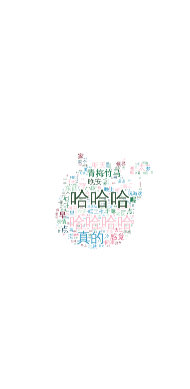

In [186]:
wordCloud(" ".join(words[0]), font, masks[1], cmap)

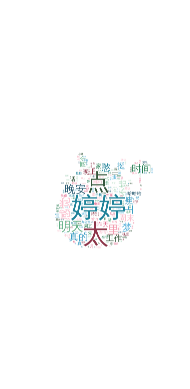

In [187]:
wordCloud(" ".join(words[1]), font, masks[1], cmap)

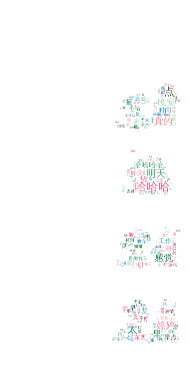

In [188]:
wordCloud(" ".join(words[0] + words[1]), font, masks[0], cmap)

### 高频词排行
列出常用的 N 个词，并且展示双方的贡献
* `wN`: 词的数目，默认为50

In [194]:
wN = 50

In [195]:
data = pd.DataFrame(
    {
        "words": words[0] + words[1],
        "L": [1] * len(words[0]) + [0] * len(words[1]),
        "F": [0] * len(words[0]) + [1] * len(words[1]),
        "S": [1] * len(words[0]) + [1] * len(words[1]),
    }
)

grouper = pd.Grouper(key="words")
data = data.groupby(grouper).sum()
data = data.sort_values(by="S", ascending=False)
data = data.iloc[:wN]

In [196]:
# 将部分无法识别的 emoji 转化为文字
tmp = data.index.to_list()
for i in range(wN):
    if tmp[i] == "😘":
        tmp[i] = "[亲亲]"
    elif tmp[i] == "😂":
        tmp[i] = "[笑哭]"
    elif tmp[i] == "🤦":
        tmp[i] = "[捂脸]"
    elif tmp[i] == "😁":
        tmp[i] = "[呲牙]"
data.index = tmp

In [223]:
!cp /usr/share/fonts/truetype/wqy/wqy-zenhei.ttc /content

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35789 (\N{CJK UNIFIED IDEOGRAPH-8BCD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3232 (\N{KANNADA LETTER TTHA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Kannada natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129300 (\N{THINKING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


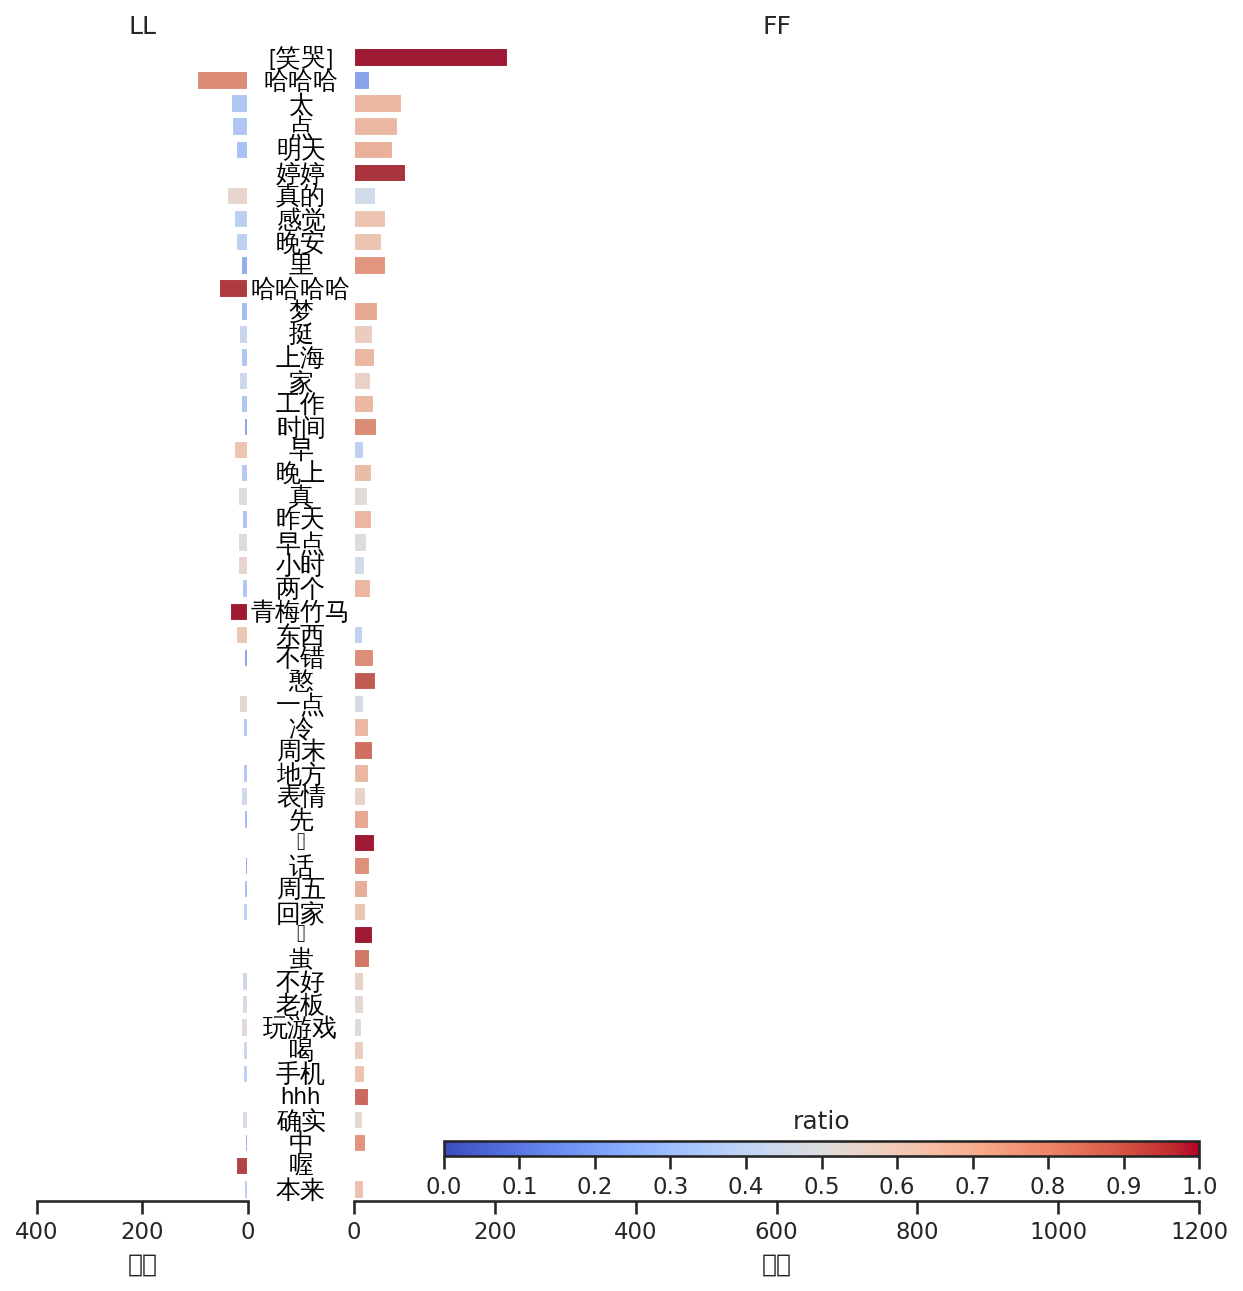

In [224]:
ratio = data["L"] / data["S"]
norm = plt.Normalize(0, 1)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)

fig = plt.figure(figsize=(10, 10), dpi=300)
grid = plt.GridSpec(1, 4, wspace=0.5)

ax0 = fig.add_subplot(grid[0, 0])
sns.barplot(x=-data["L"], y=data.index, ax=ax0, hue=ratio, hue_norm=norm, palette="coolwarm")
ax1 = fig.add_subplot(grid[0, 1:])
sns.barplot(x=data["F"], y=data.index, ax=ax1, hue=(1 - ratio), hue_norm=norm, palette="coolwarm")

ax0.set_xlabel("词频")
ax0.set_ylabel("")
ax0.set_xticks(range(-400, 1, 200))
ax0.set_xticklabels([400, 200, 0])
ax0.set_xlim(-400, 0)
ax0.set_yticks([])
ax0.spines["left"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.set_title("LL")
ax0.get_legend().remove()

ax1.set_xlabel("词频")
ax1.set_ylabel("")
ax1.set_xticks(range(0, 1201, 200))
ax1.set_xticklabels([0, 200, 400, 600, 800, 1000, 1200])
ax1.set_xlim(0, 1200)
ax1.set_yticks([])
ax1.spines["left"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_title("FF")
ax1.get_legend().remove()

axpos = ax1.get_position()
caxpos = mtransforms.Bbox.from_extents(axpos.x0 + 0.06, axpos.y0 + 0.03, axpos.x1, axpos.y0 + 0.04)
cax = ax1.figure.add_axes(caxpos)

locator = mticker.MultipleLocator(0.1)
formatter = mticker.StrMethodFormatter("{x:.1f}")
cax.figure.colorbar(sm, cax=cax, orientation="horizontal", ticks=locator, format=formatter)
# cax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
cax.set_title("ratio")

x0 = ax0.get_position().x1
x1 = ax1.get_position().x0
xm = (x0 + x1) / 2
y0 = ax0.get_position().y0
y1 = ax0.get_position().y1

for i in range(wN):
    fig.text(
        xm, y0 + (y1 - y0) * (wN - i - 0.5) / wN, data.index[i],
        color="black", ha="center", va="center", fontproperties=fp
    )

fig.set_dpi(150)
plt.show()
plt.close()

## 情感分析
使用 `paddlenlp` 进行情感分析，得到的分数在 [-1, 1] 之间，越小越消极，越大越积极

In [225]:
dfE = df.query("Type == 1")[["IsSender", "StrContent", "StrTime", "hour"]]
dfE.index = range(len(dfE))

In [226]:
senta = Taskflow("sentiment_analysis")

In [227]:
scores = pd.DataFrame(senta([textFilter(i) for i in dfE["StrContent"].to_list()]))
scores.loc[scores["label"] == "negative", "score"] = 1 - scores.loc[scores["label"] == "negative", "score"]

In [228]:
dfE["score"] = scores["score"]
dfE["score"] = 2 * dfE["score"] - 1
dfE["Person"] = dfE.apply(lambda x: labels[x["IsSender"]], axis=1)

dfEs = [dfE.query("IsSender == 0"), dfE.query("IsSender == 1")]

### 年度总体情感分布

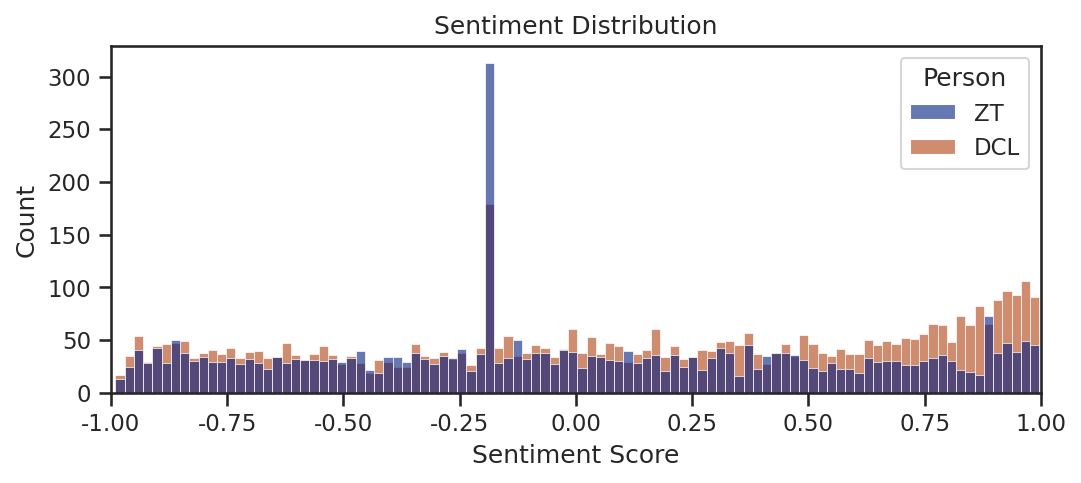

In [229]:
ax = sns.histplot(data=dfE, x="score", hue="Person", palette="dark", alpha=0.6, bins=100)

ax.set_xlabel("Sentiment Score")
ax.set_ylabel("Count")
ax.set_title("Sentiment Distribution")
ax.set_xlim(-1, 1)

ax.figure.set_size_inches(8, 3)
ax.figure.set_dpi(150)
plt.show()

### 按周统计平均情感指数

In [231]:
def weekAvgSenScore(df):
    grouper = pd.Grouper(key="StrTime", freq="W-MON")
    data = df.groupby(grouper)["score"].mean().to_frame()
    data.index = pd.date_range(start=wStart, end=wEnd, freq="W-MON").strftime("%m-%d")
    data.columns = ["score"]

    vM = data["score"].abs().max()
    norm = plt.Normalize(-vM, vM)
    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)

    ax = sns.barplot(x=data.index, y=data["score"], hue=data["score"], hue_norm=norm, palette="coolwarm")
    ax.set_xlabel("Date")
    plt.xticks(rotation=60)
    for bar in ax.containers:
        ax.bar_label(bar, fontsize=10, fmt="%.2f")
    ax.get_legend().remove()

    axpos = ax.get_position()
    caxpos = mtransforms.Bbox.from_extents(axpos.x1 + 0.02, axpos.y0, axpos.x1 + 0.03, axpos.y1)
    cax = ax.figure.add_axes(caxpos)

    locator = mticker.MultipleLocator(0.05)
    formatter = mticker.StrMethodFormatter("{x:.2f}")
    cax.figure.colorbar(sm, cax=cax, ticks=locator, format=formatter)

    ax.figure.set_size_inches(20, 8)
    ax.figure.set_dpi(150)
    plt.show()
    plt.close()

    return data["score"]

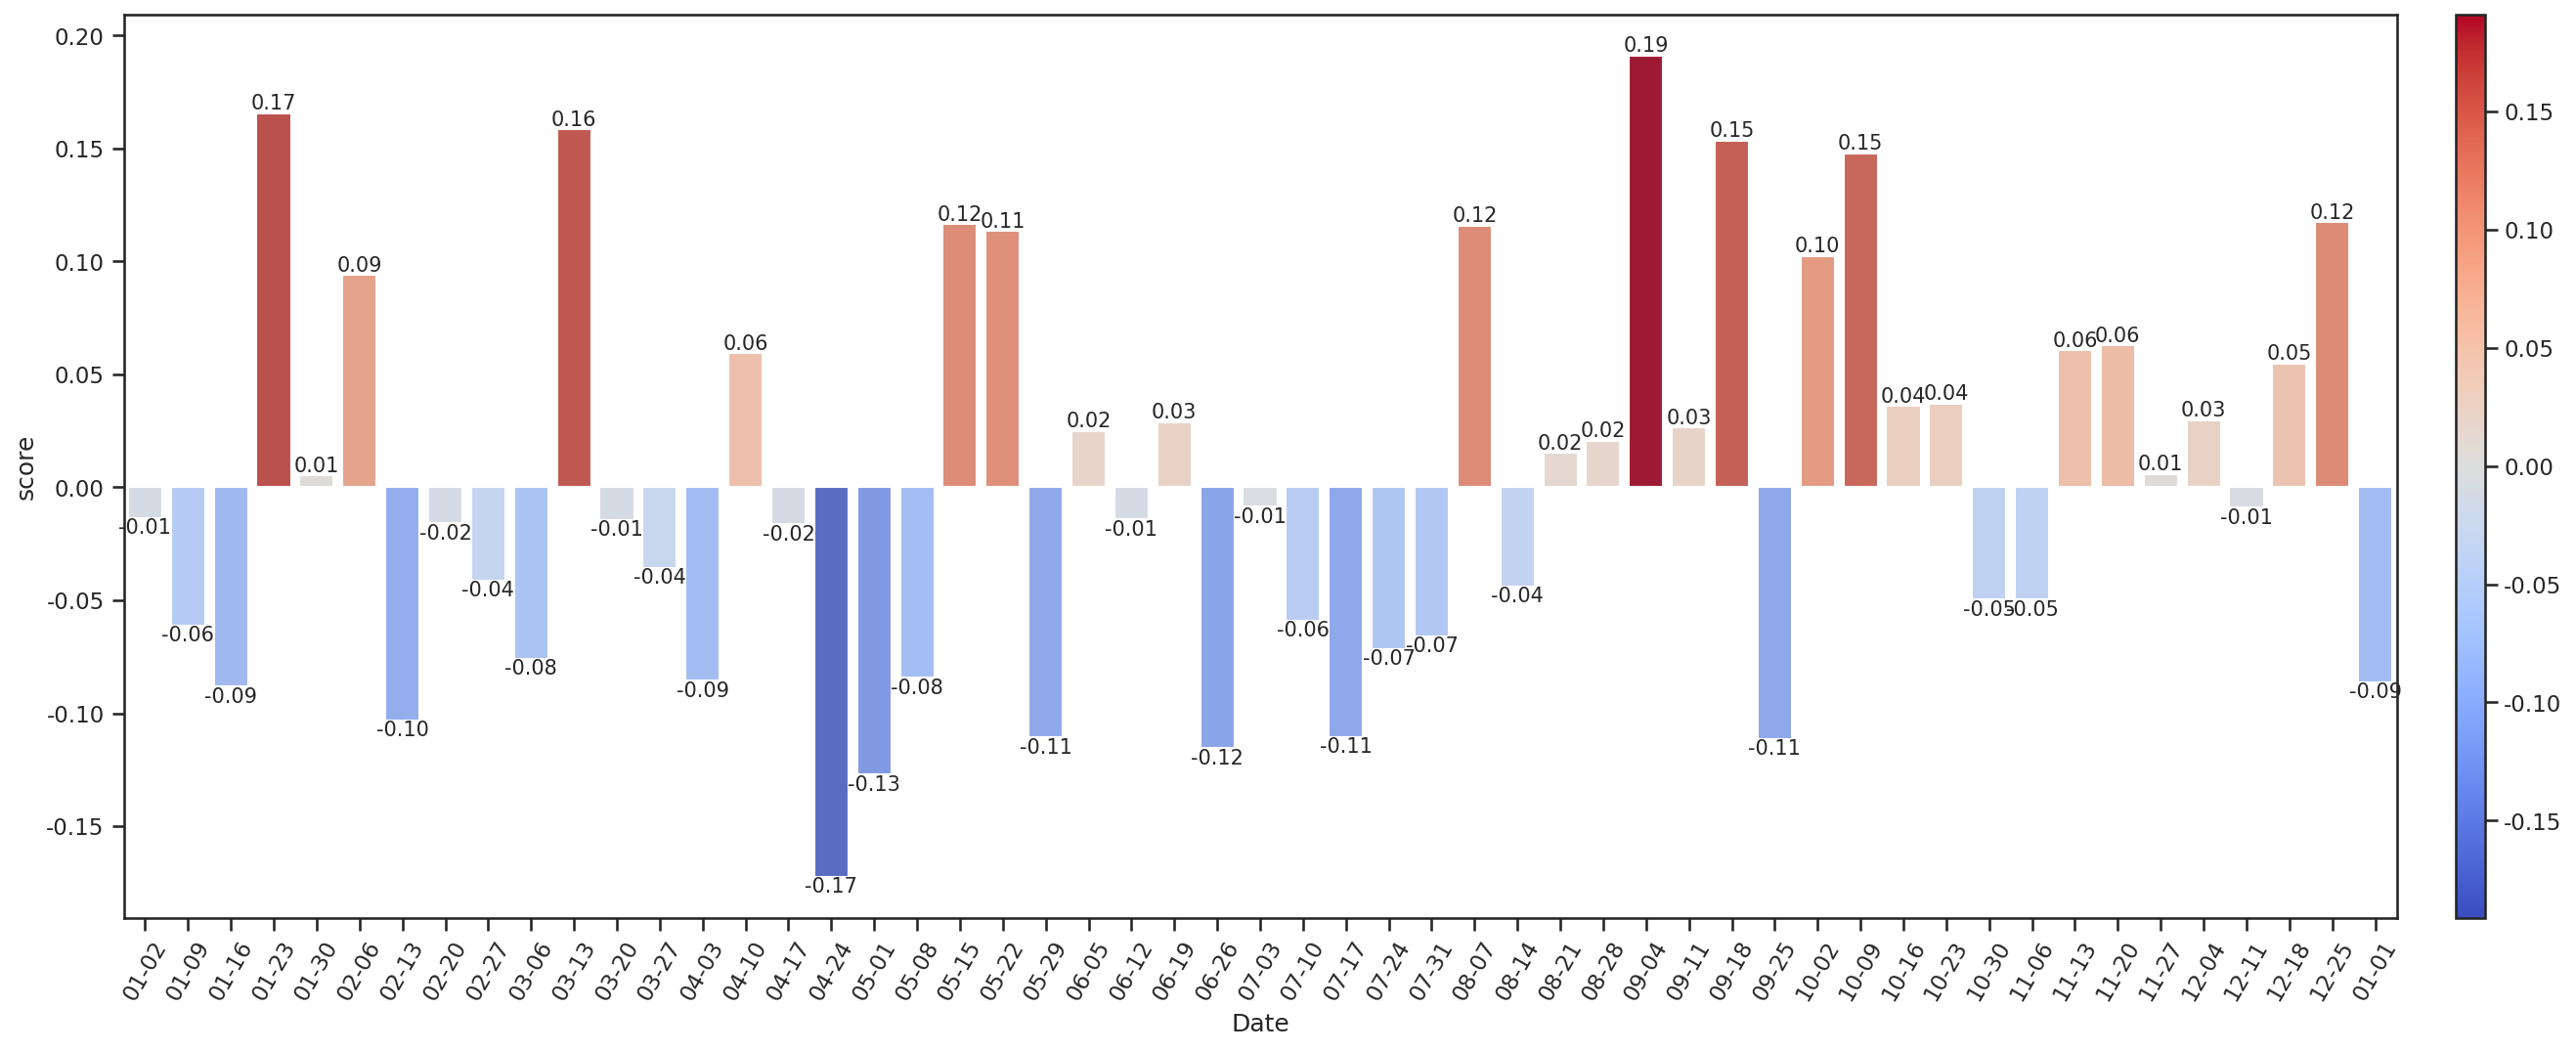

In [232]:
avgSenScore0 = weekAvgSenScore(dfEs[0])

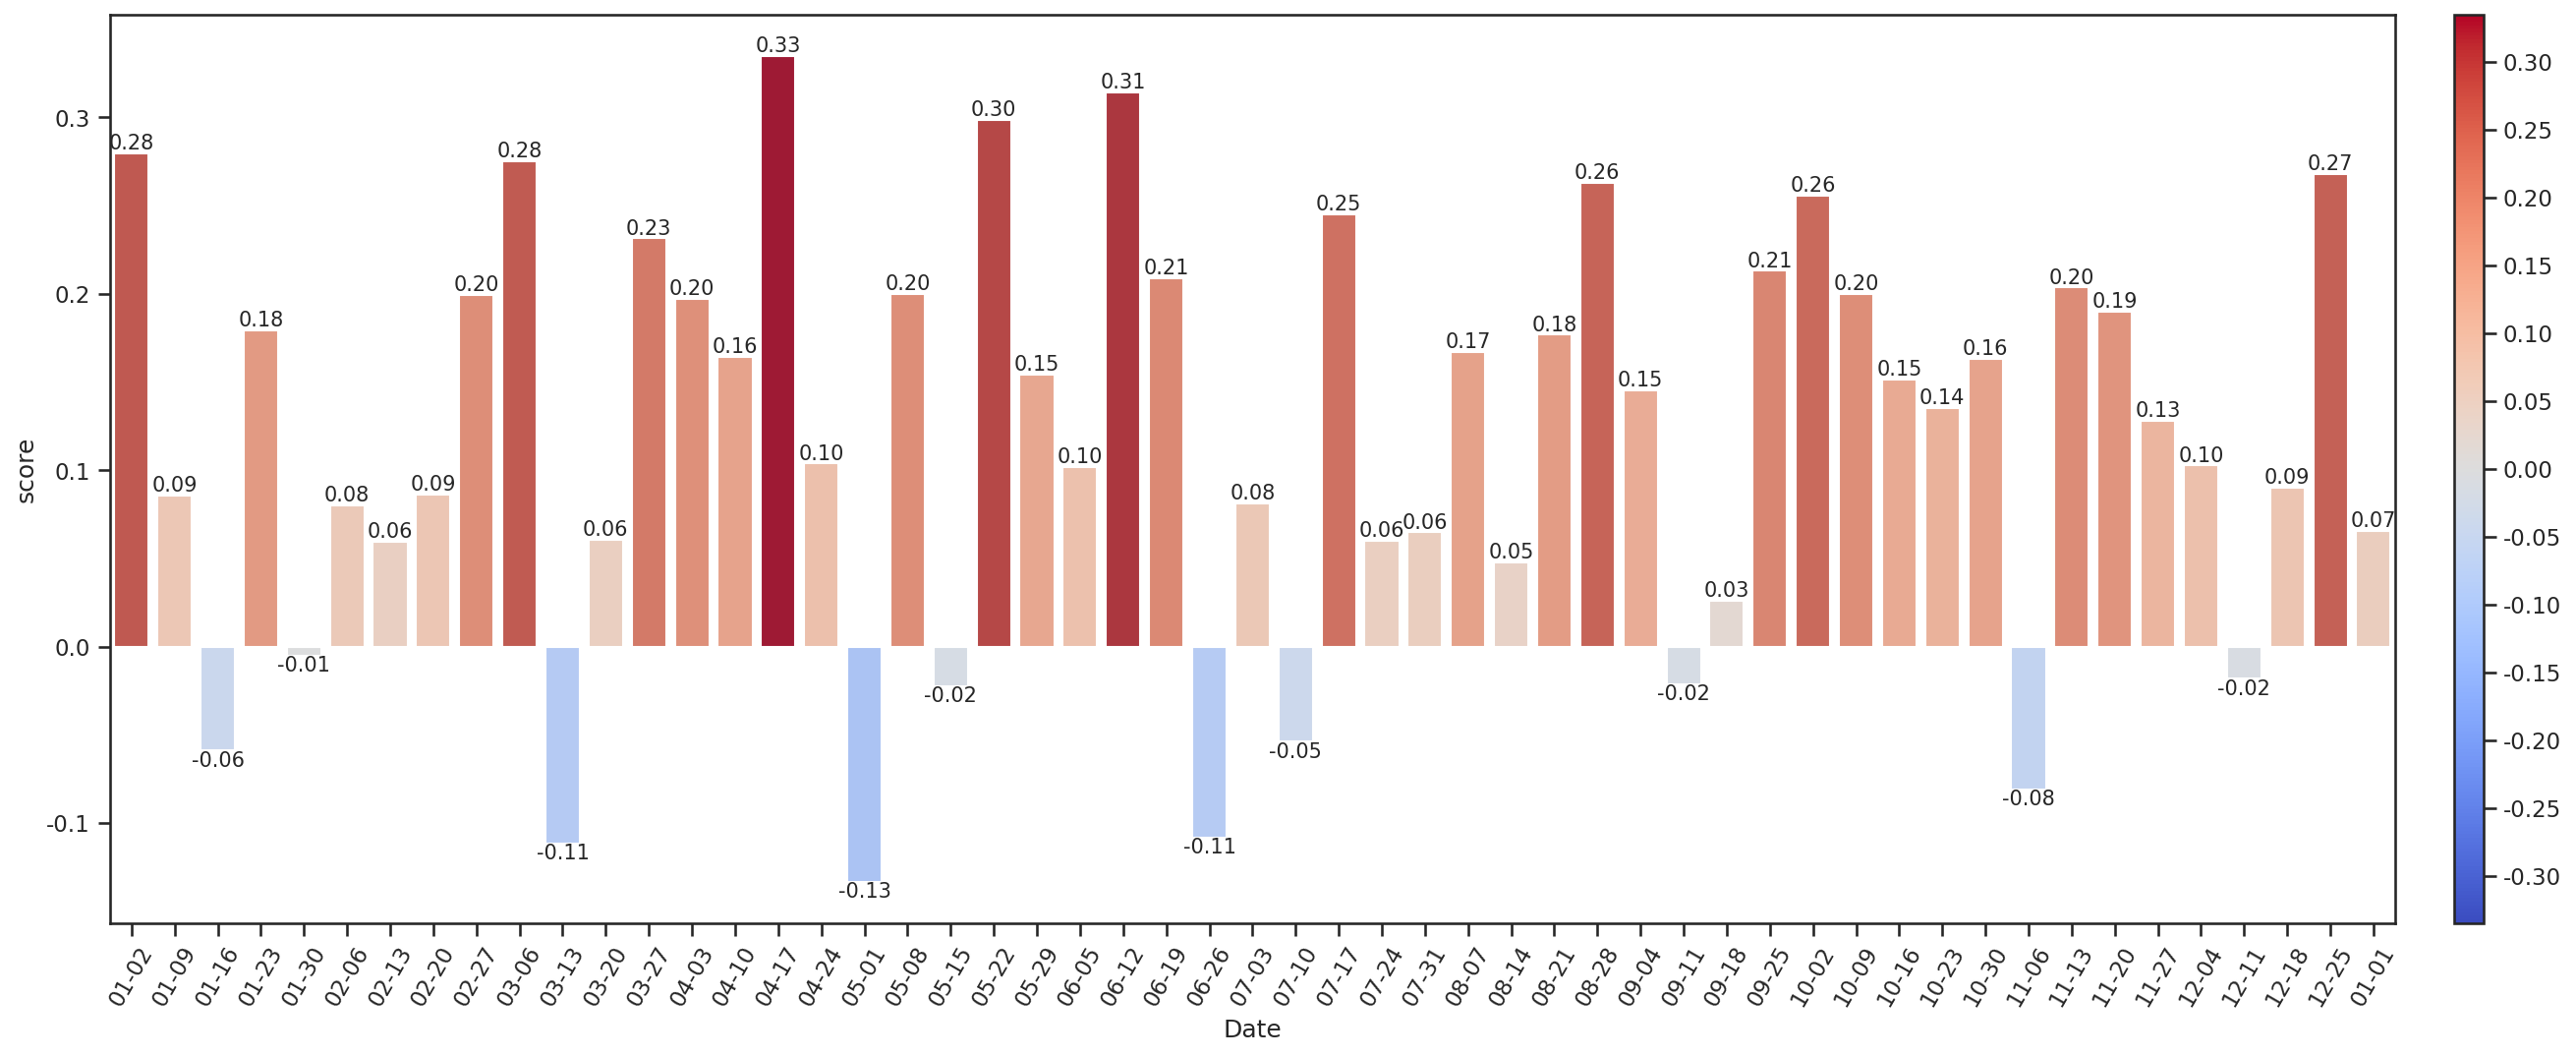

In [233]:
avgSenScore1 = weekAvgSenScore(dfEs[1])

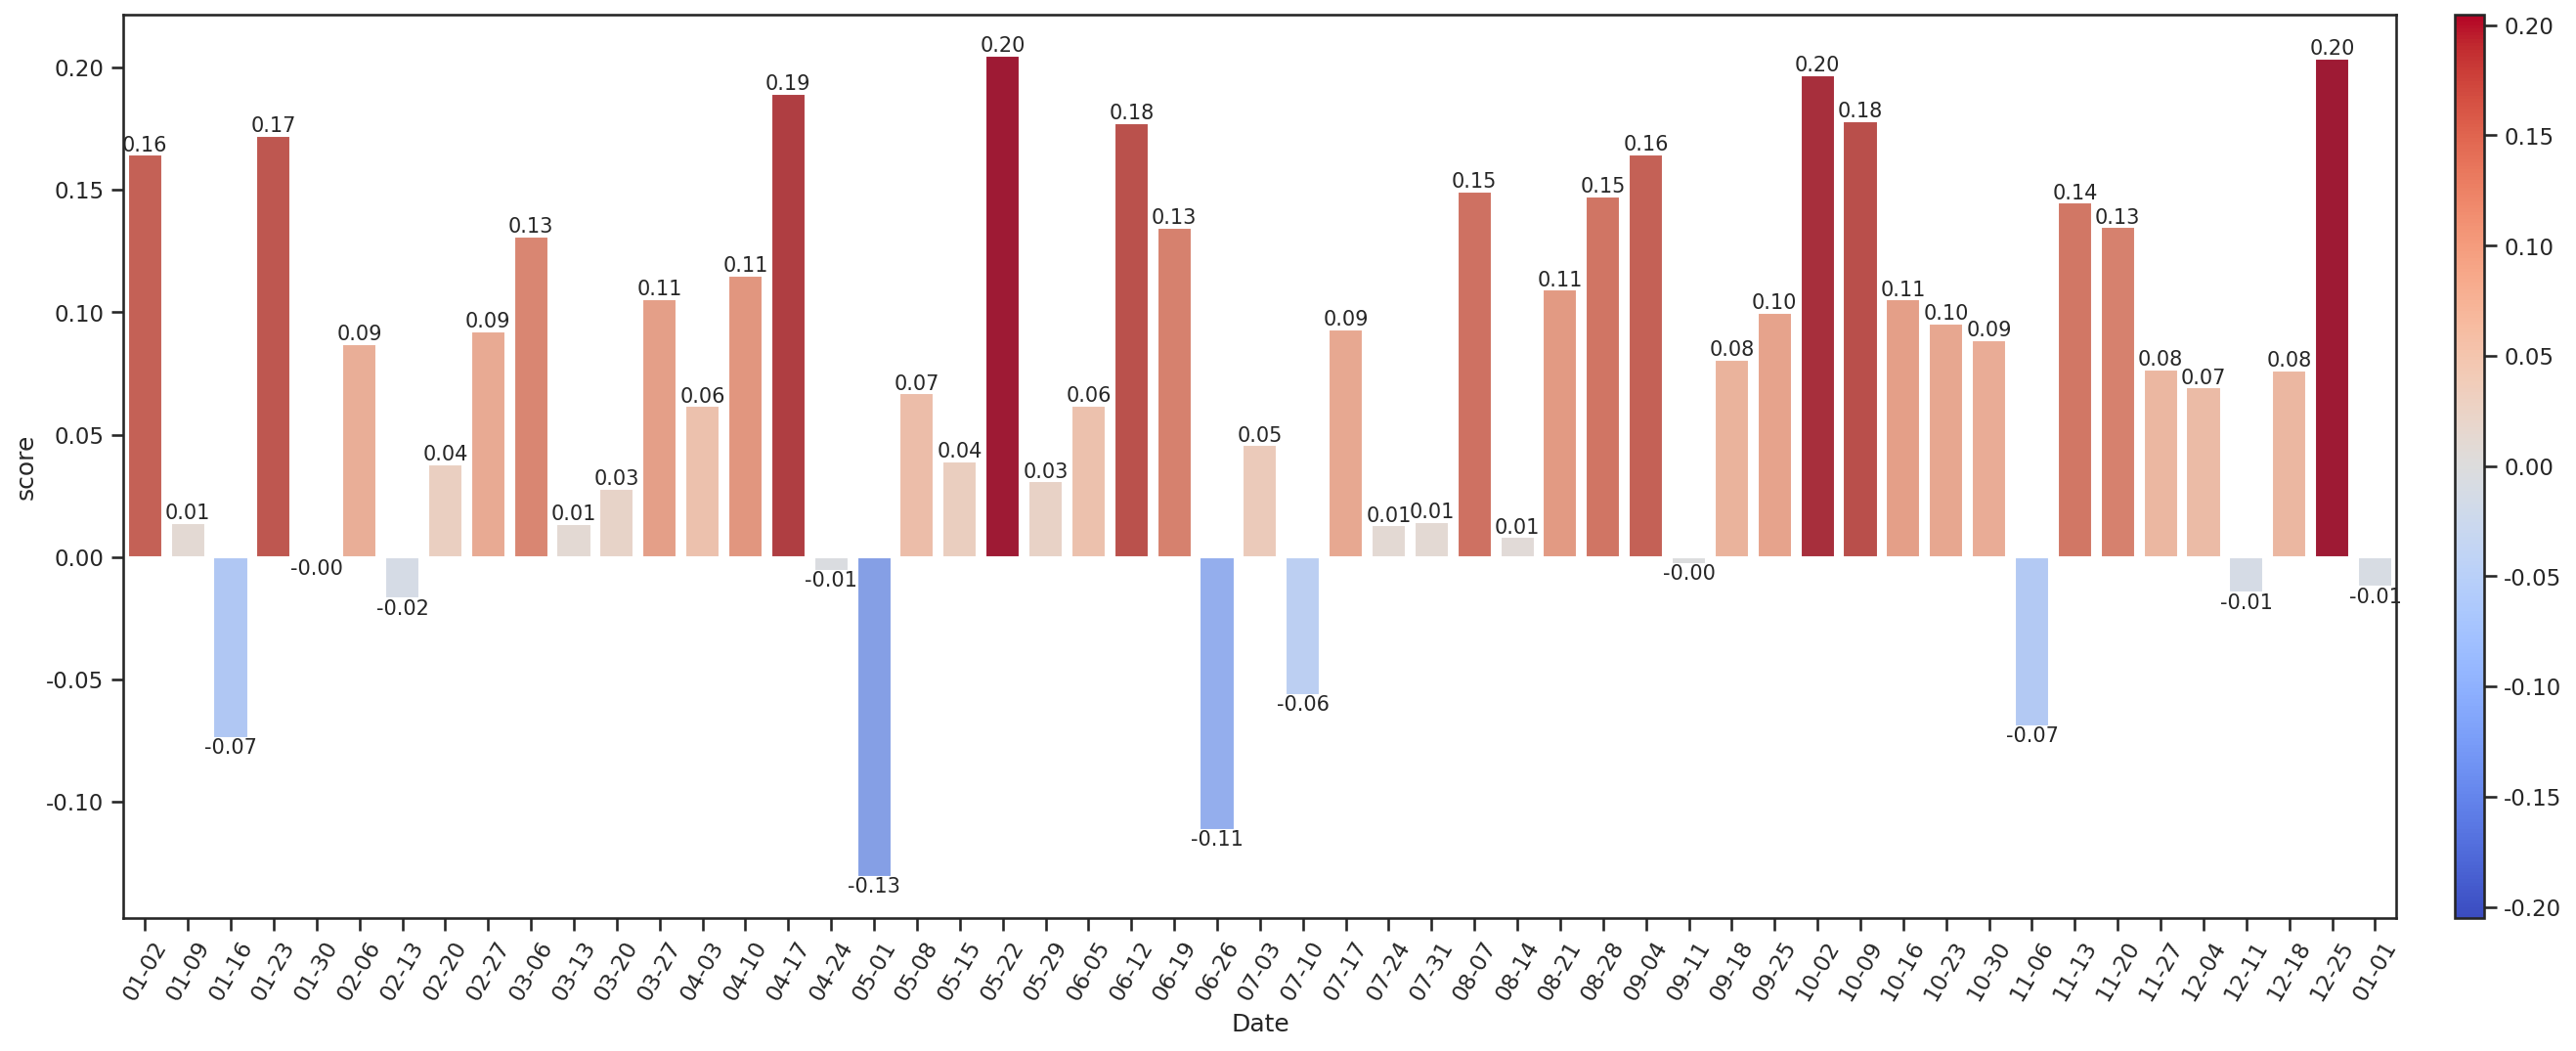

In [234]:
_ = weekAvgSenScore(dfE)

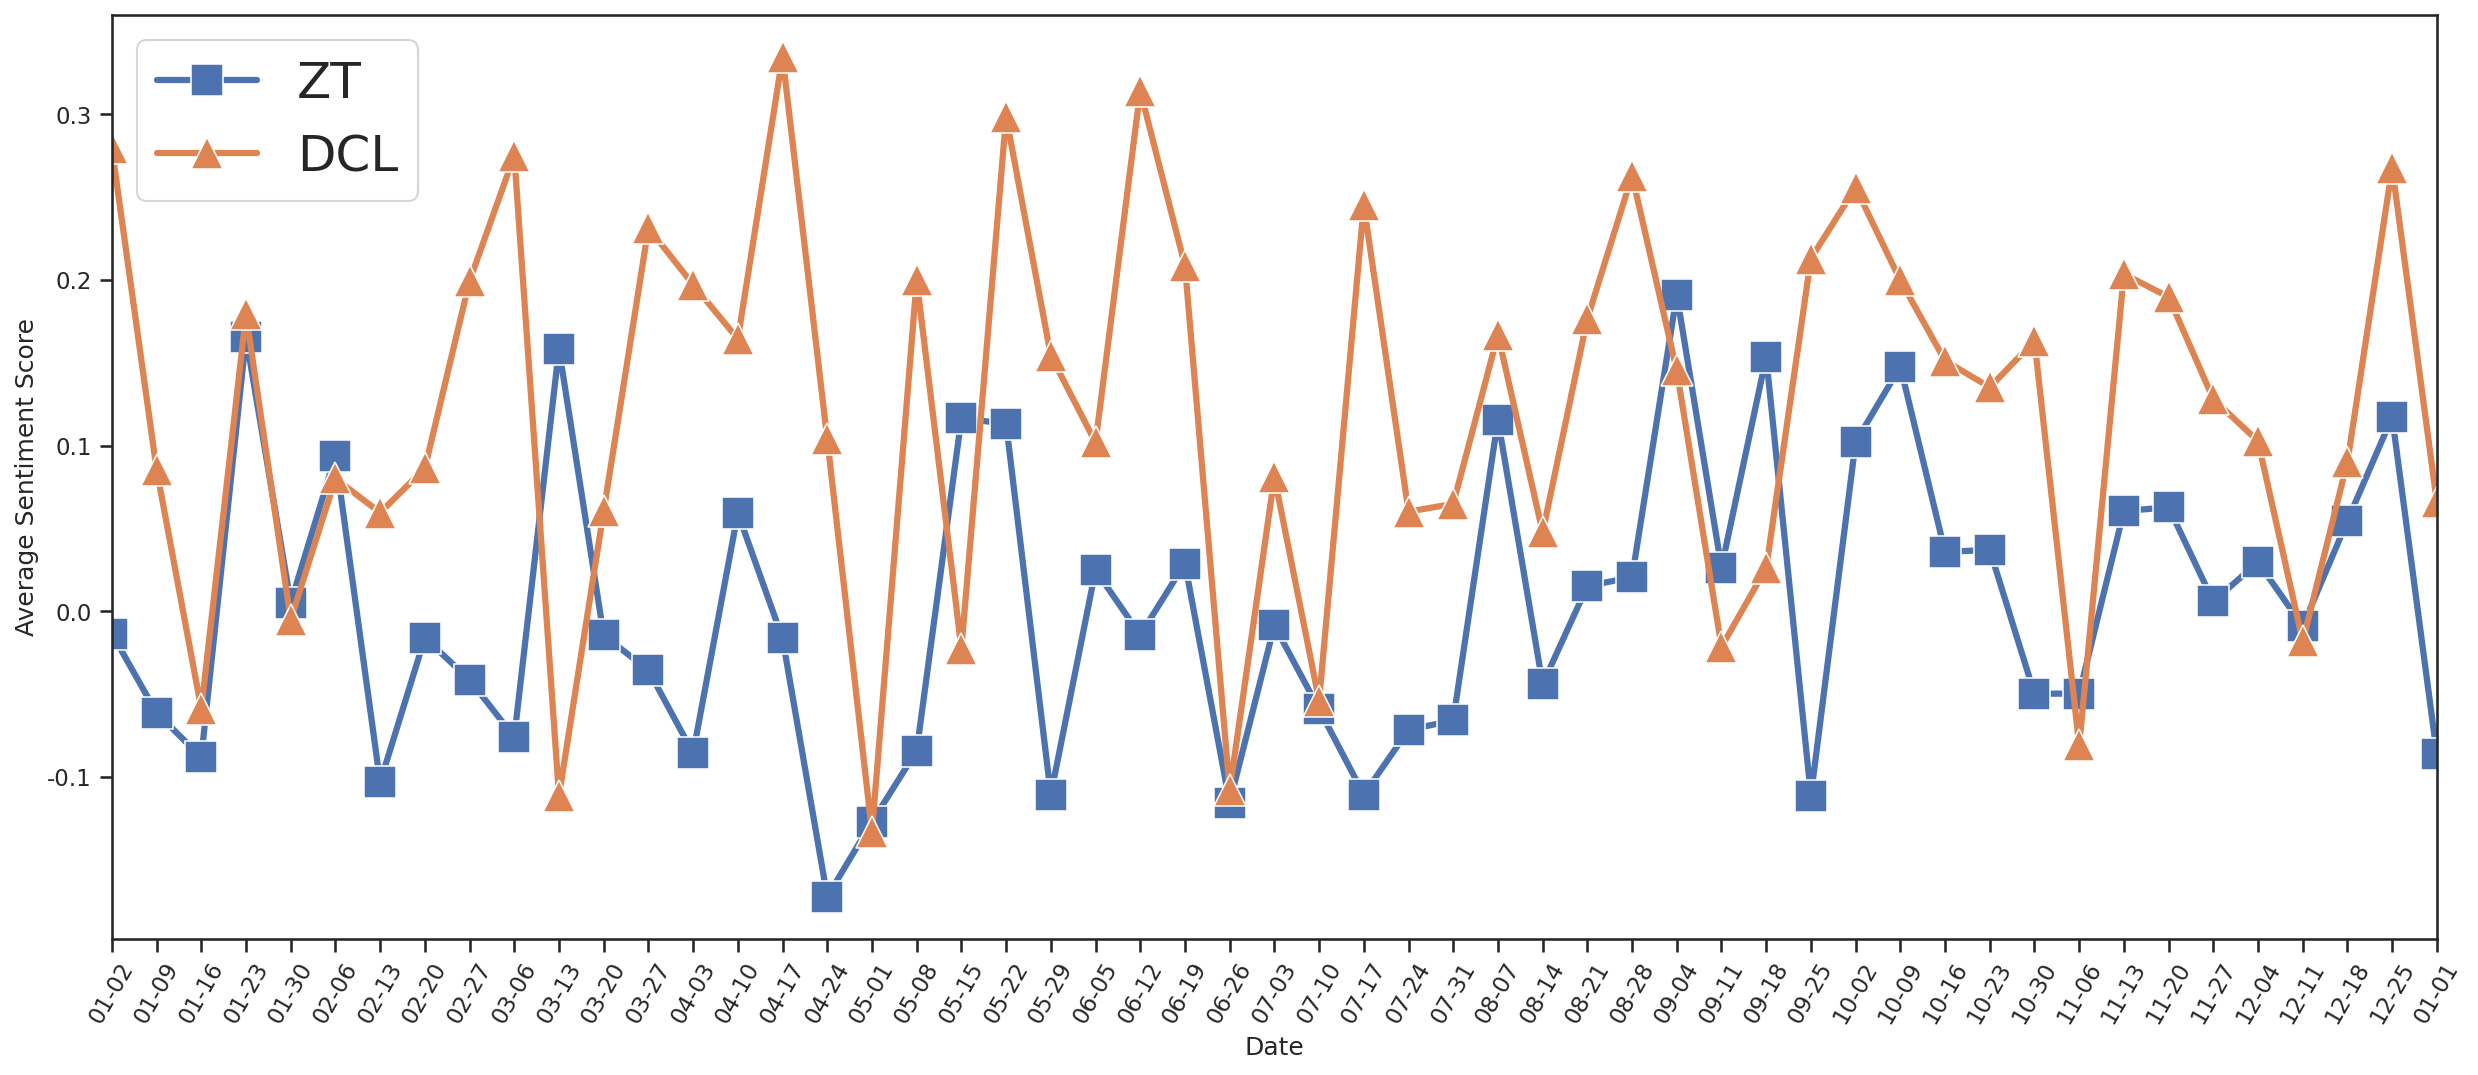

In [235]:
ax = sns.lineplot(data=avgSenScore0, linewidth=3, marker="s", markersize=15, label=labels[0])
ax = sns.lineplot(data=avgSenScore1, linewidth=3, marker="^", markersize=15, ax=ax, label=labels[1])

ax.set_xlabel("Date")
plt.xticks(rotation=60)
ax.set_ylabel("Average Sentiment Score")
ax.set_xlim(0, 52)
ax.legend(prop={"size": 24})

ax.figure.set_size_inches(20, 8)
ax.figure.set_dpi(150)
plt.show()
plt.close()

### 按周统计累计情感指数

In [236]:
def weekTotSenScore(df):
    grouper = pd.Grouper(key="StrTime", freq="W-MON")
    data = df.groupby(grouper)["score"].sum().to_frame()
    data.index = pd.date_range(start=wStart, end=wEnd, freq="W-MON").strftime("%m-%d")
    data.columns = ["score"]

    vM = data["score"].abs().max()
    norm = plt.Normalize(-vM, vM)
    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)

    ax = sns.barplot(x=data.index, y=data["score"], hue=data["score"], hue_norm=norm, palette="coolwarm")
    ax.set_xlabel("Date")
    plt.xticks(rotation=60)
    for bar in ax.containers:
        ax.bar_label(bar, fontsize=10, fmt="%.2f")
    ax.get_legend().remove()

    axpos = ax.get_position()
    caxpos = mtransforms.Bbox.from_extents(axpos.x1 + 0.02, axpos.y0, axpos.x1 + 0.03, axpos.y1)
    cax = ax.figure.add_axes(caxpos)

    locator = mticker.MultipleLocator(20)
    formatter = mticker.StrMethodFormatter("{x:.2f}")
    cax.figure.colorbar(sm, cax=cax, ticks=locator, format=formatter)

    ax.figure.set_size_inches(20, 8)
    ax.figure.set_dpi(150)
    plt.show()
    plt.close()

    return data["score"]

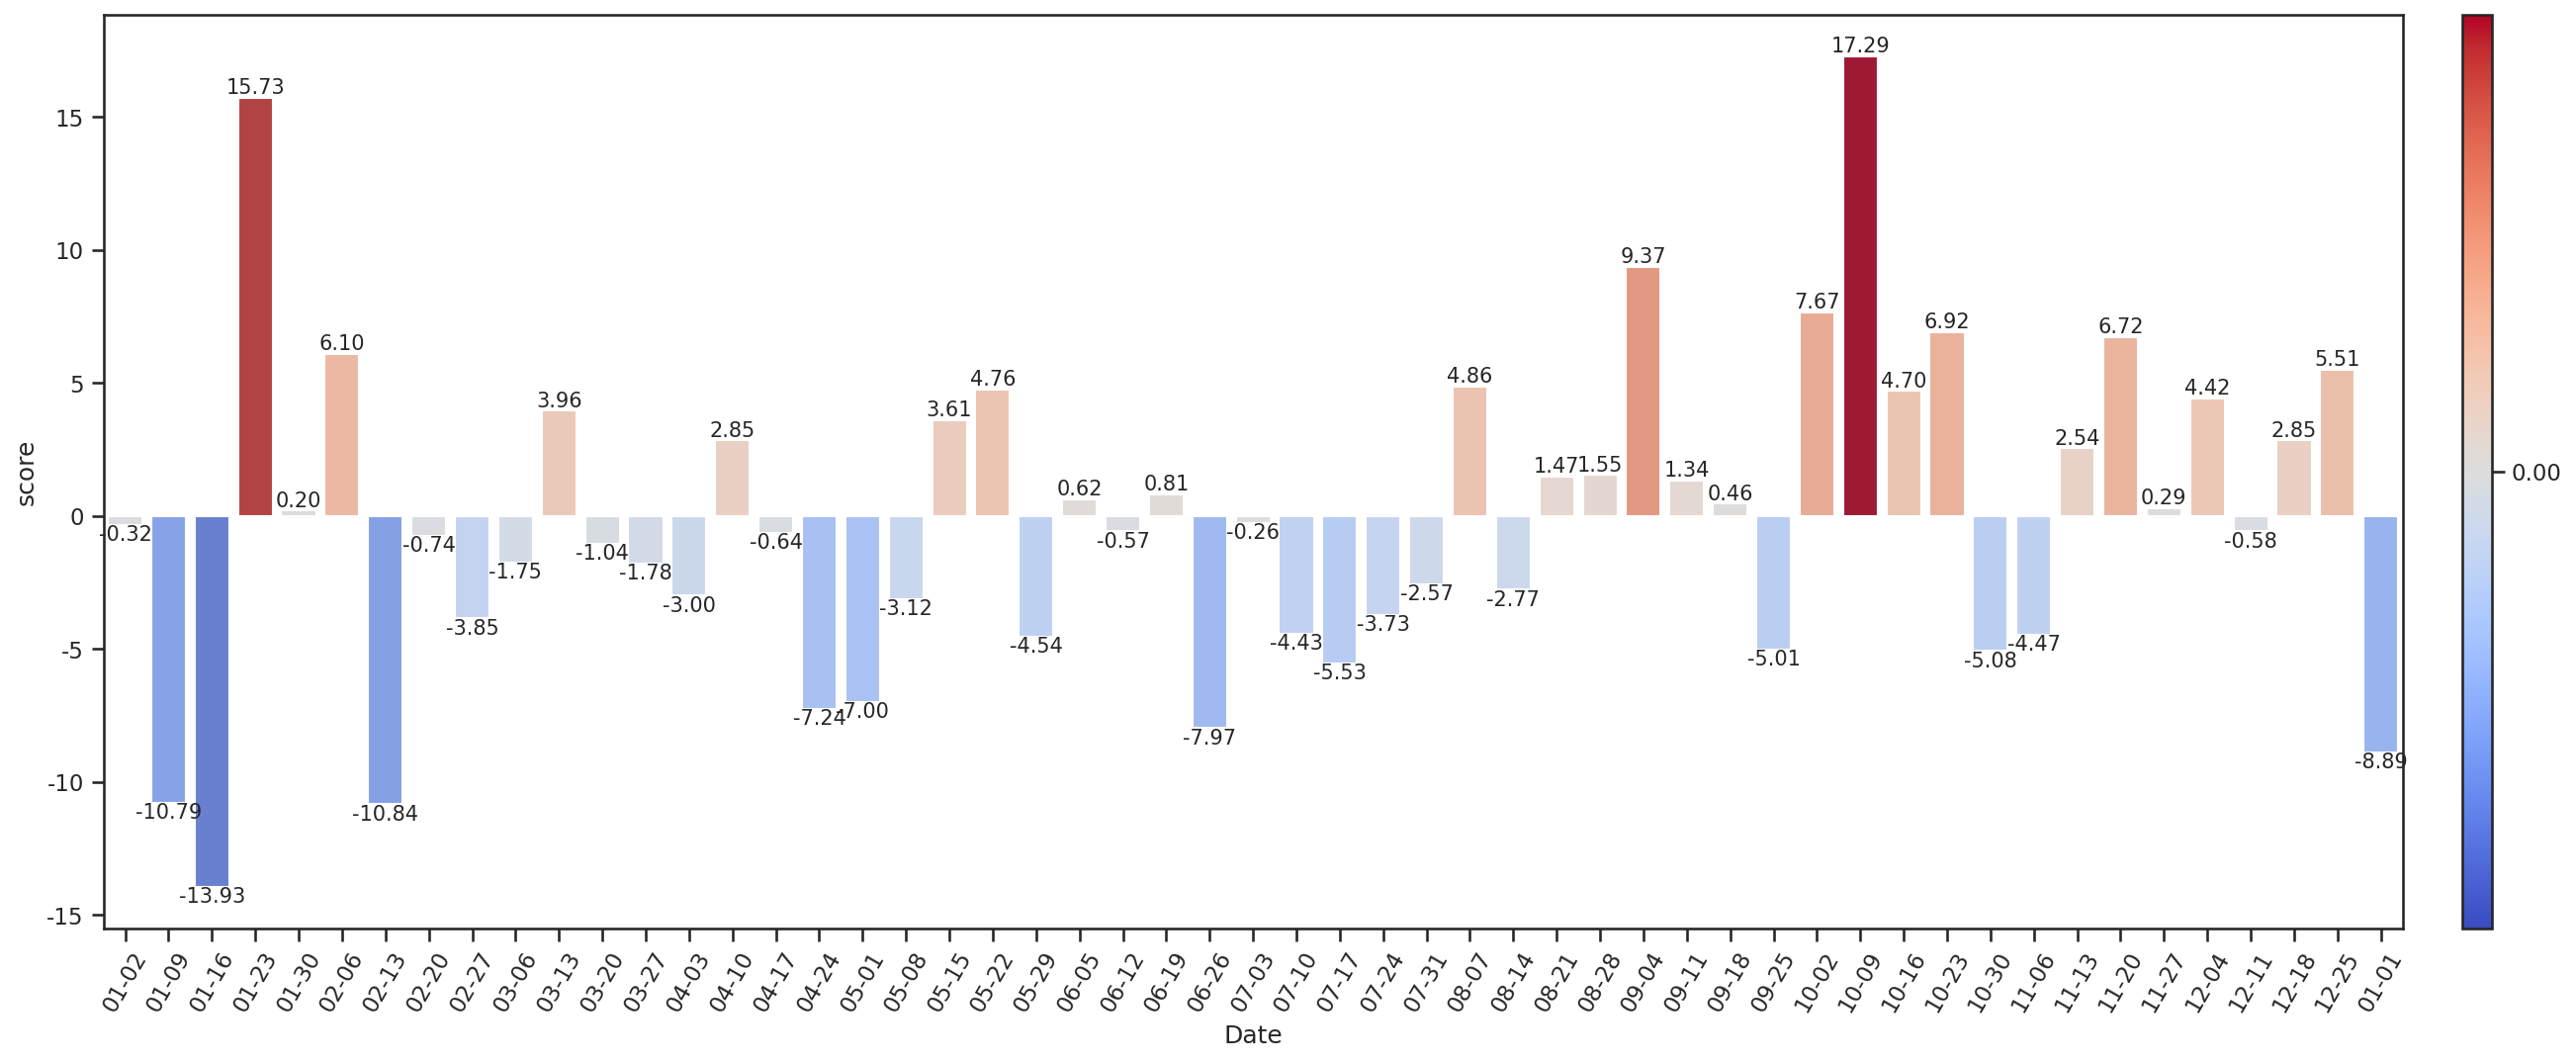

In [237]:
totSenScore0 = weekTotSenScore(dfEs[0])

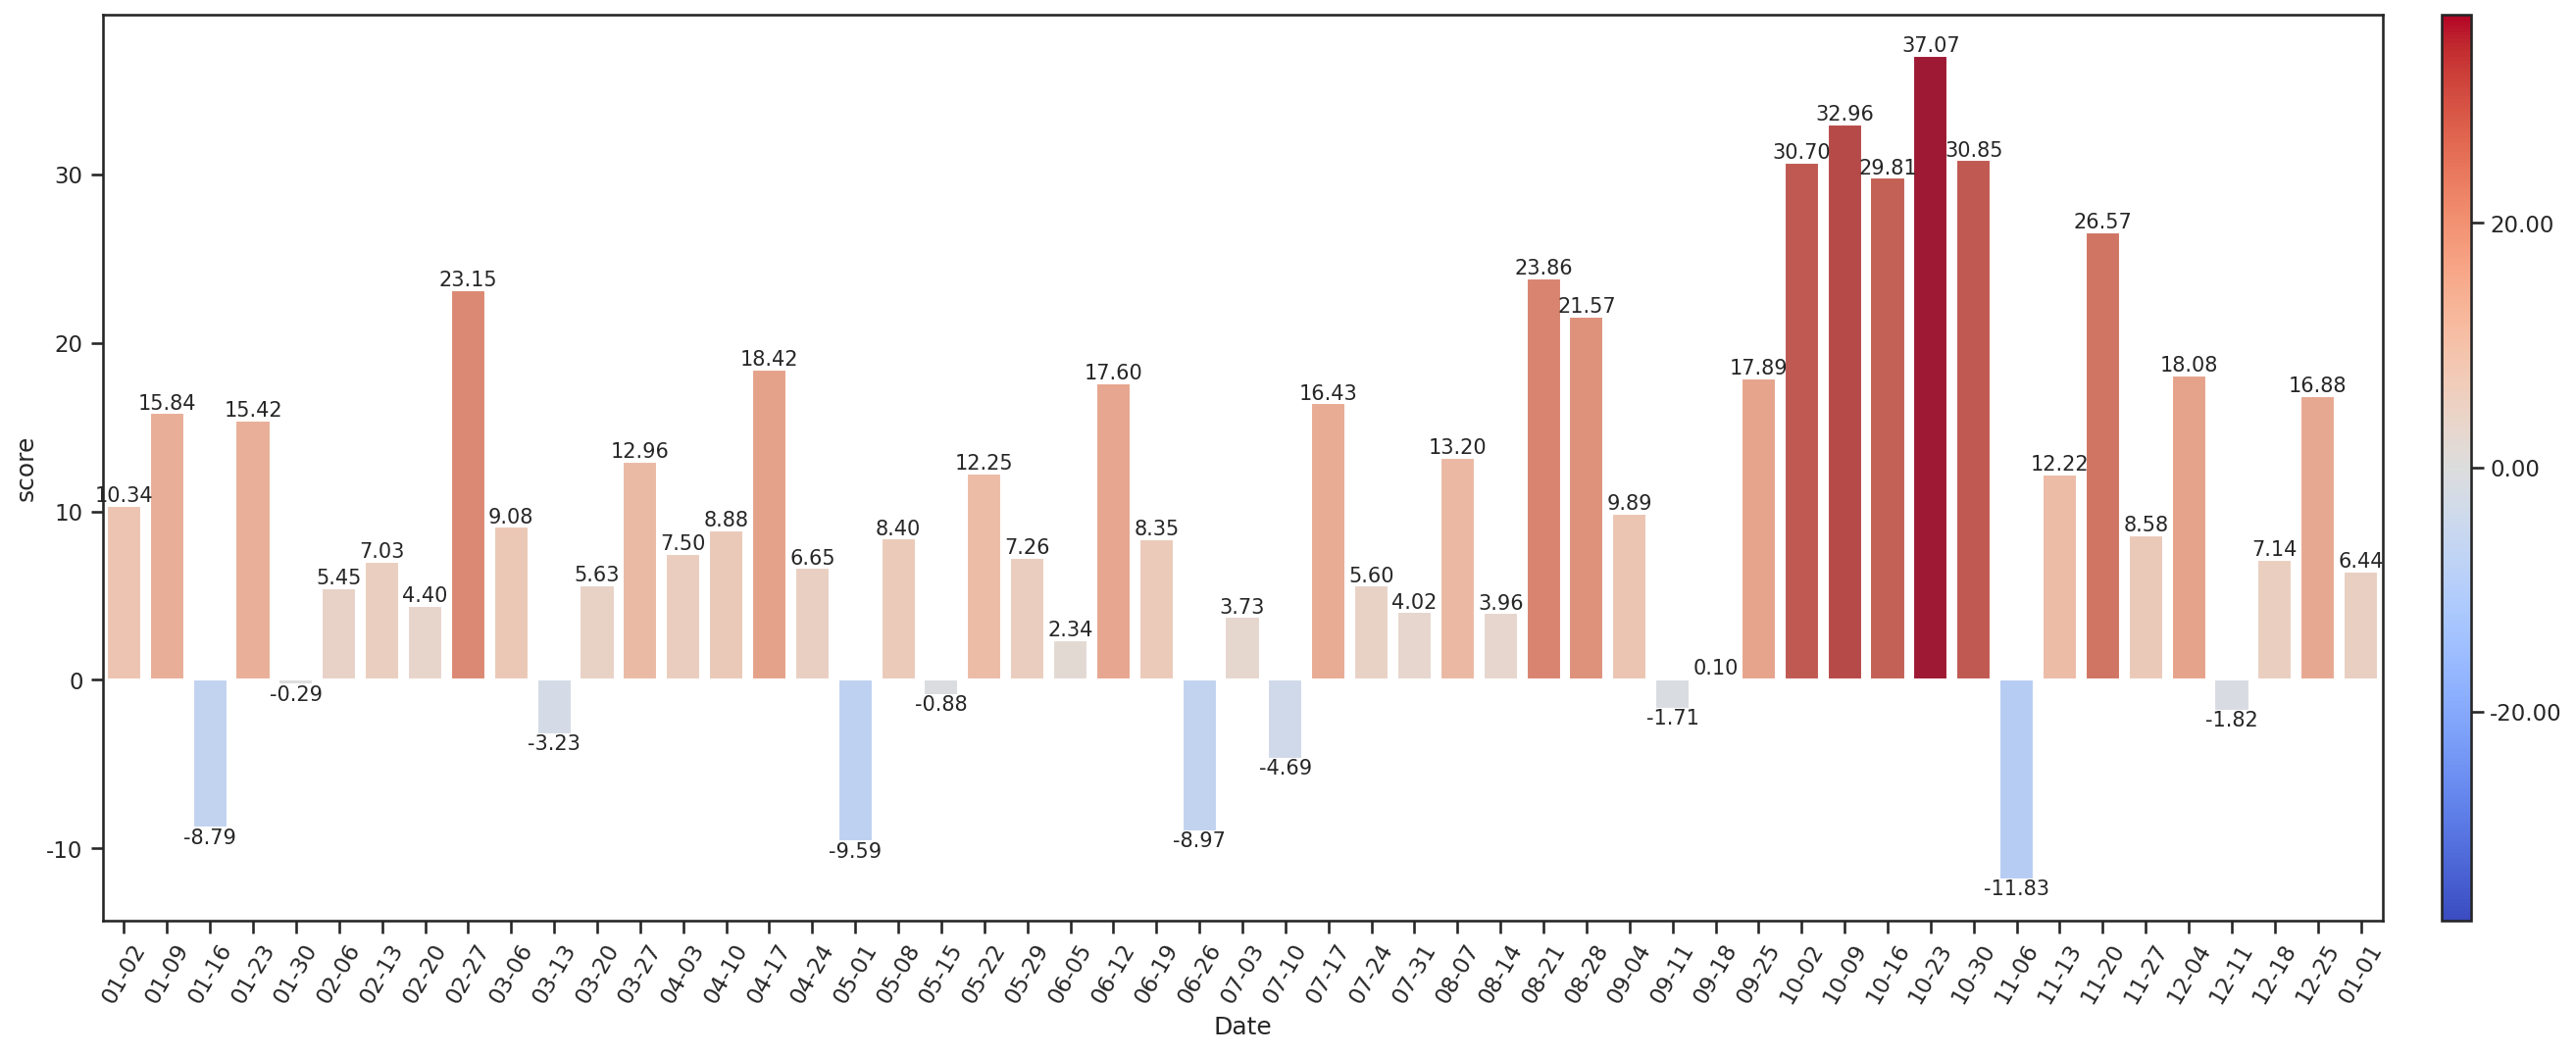

In [238]:
totSenScore1 = weekTotSenScore(dfEs[1])

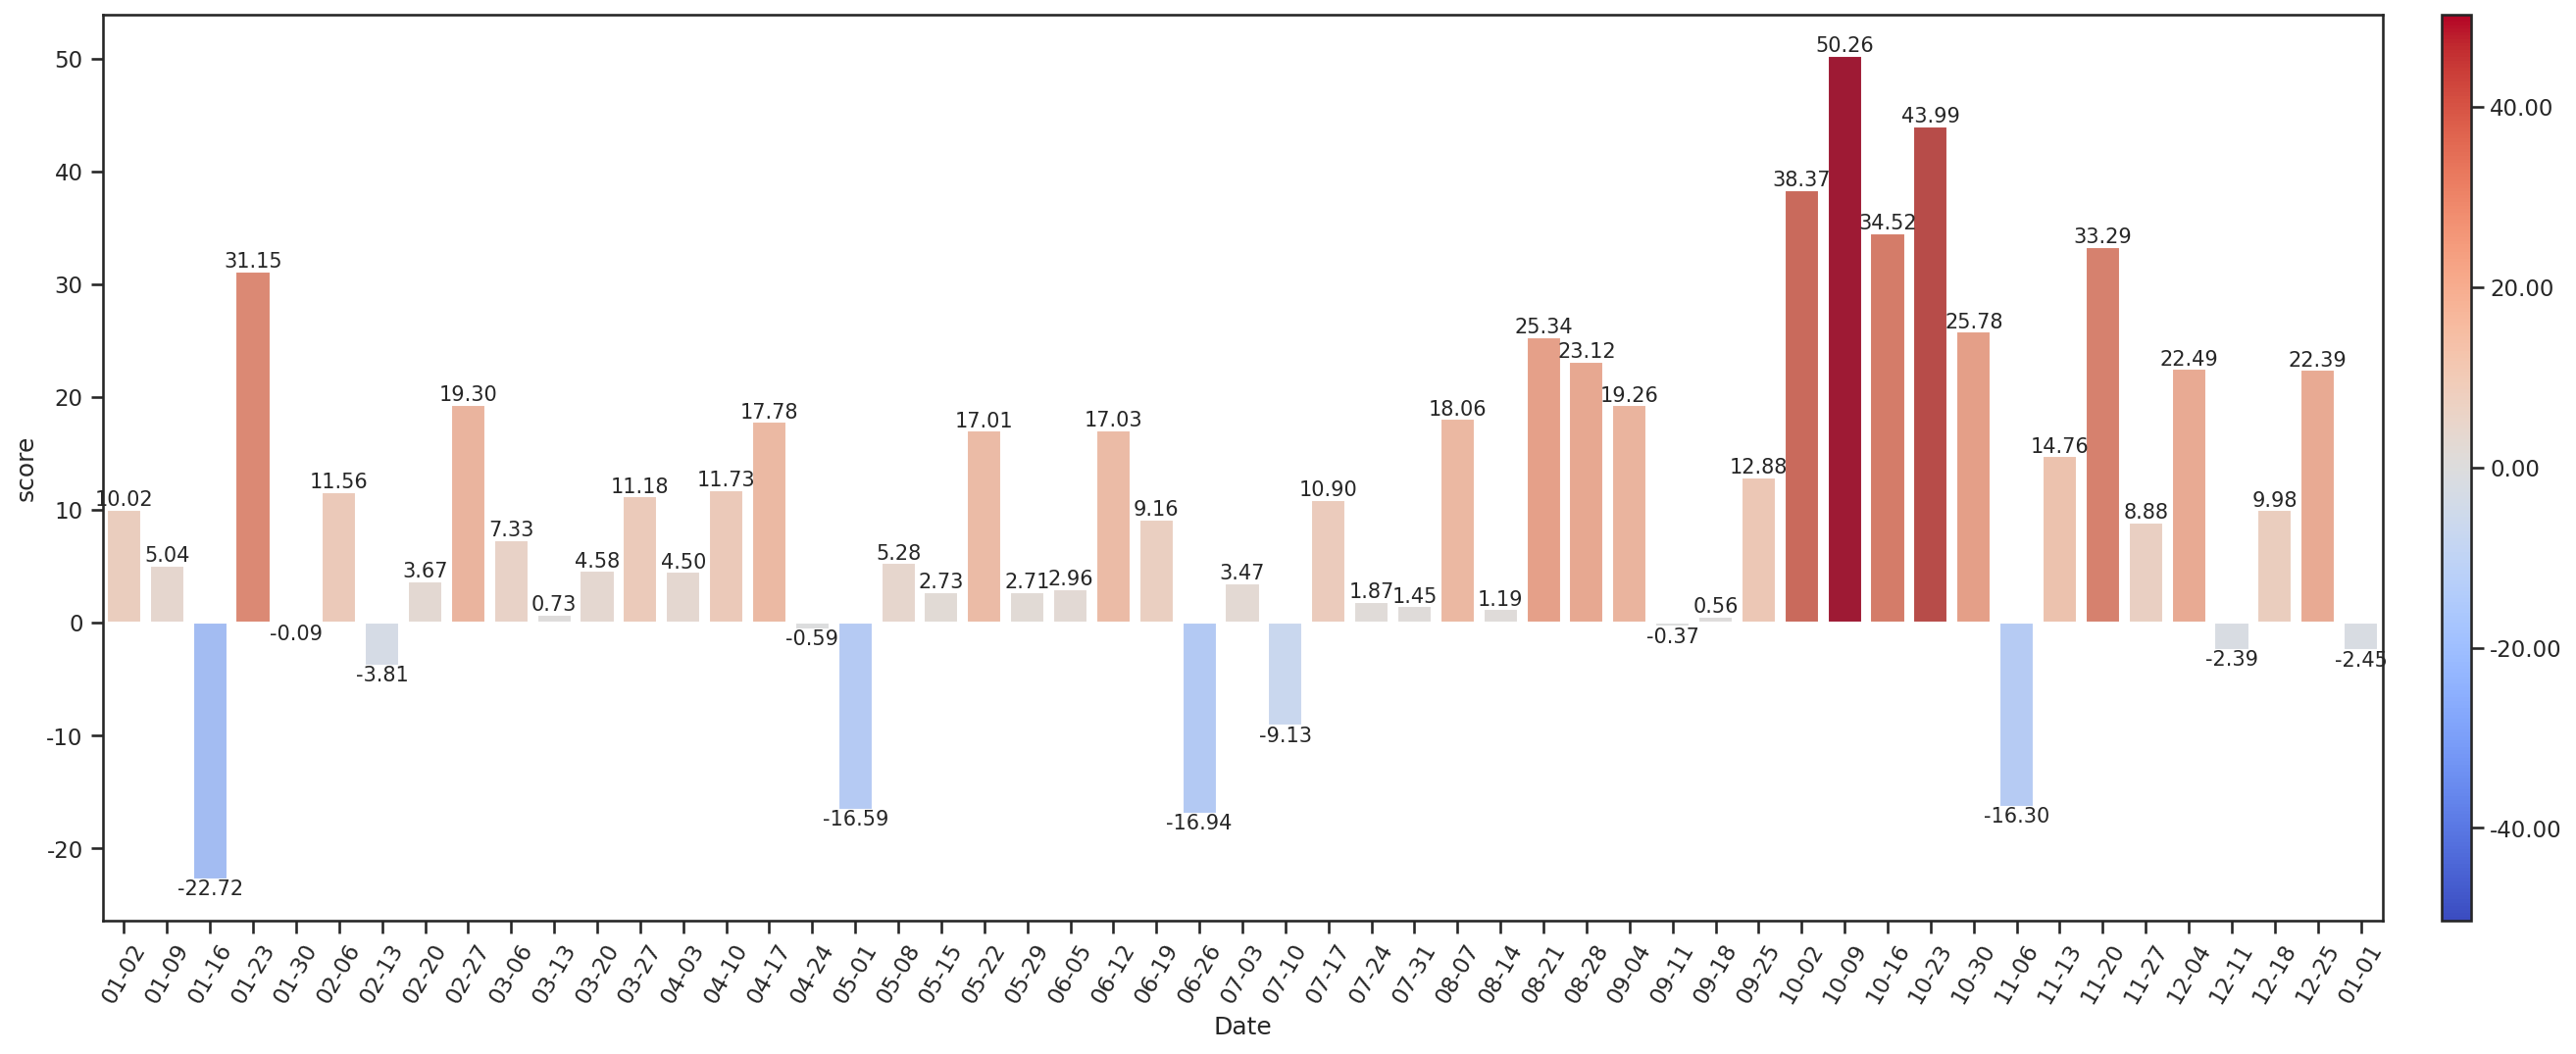

In [239]:
_ = weekTotSenScore(dfE)

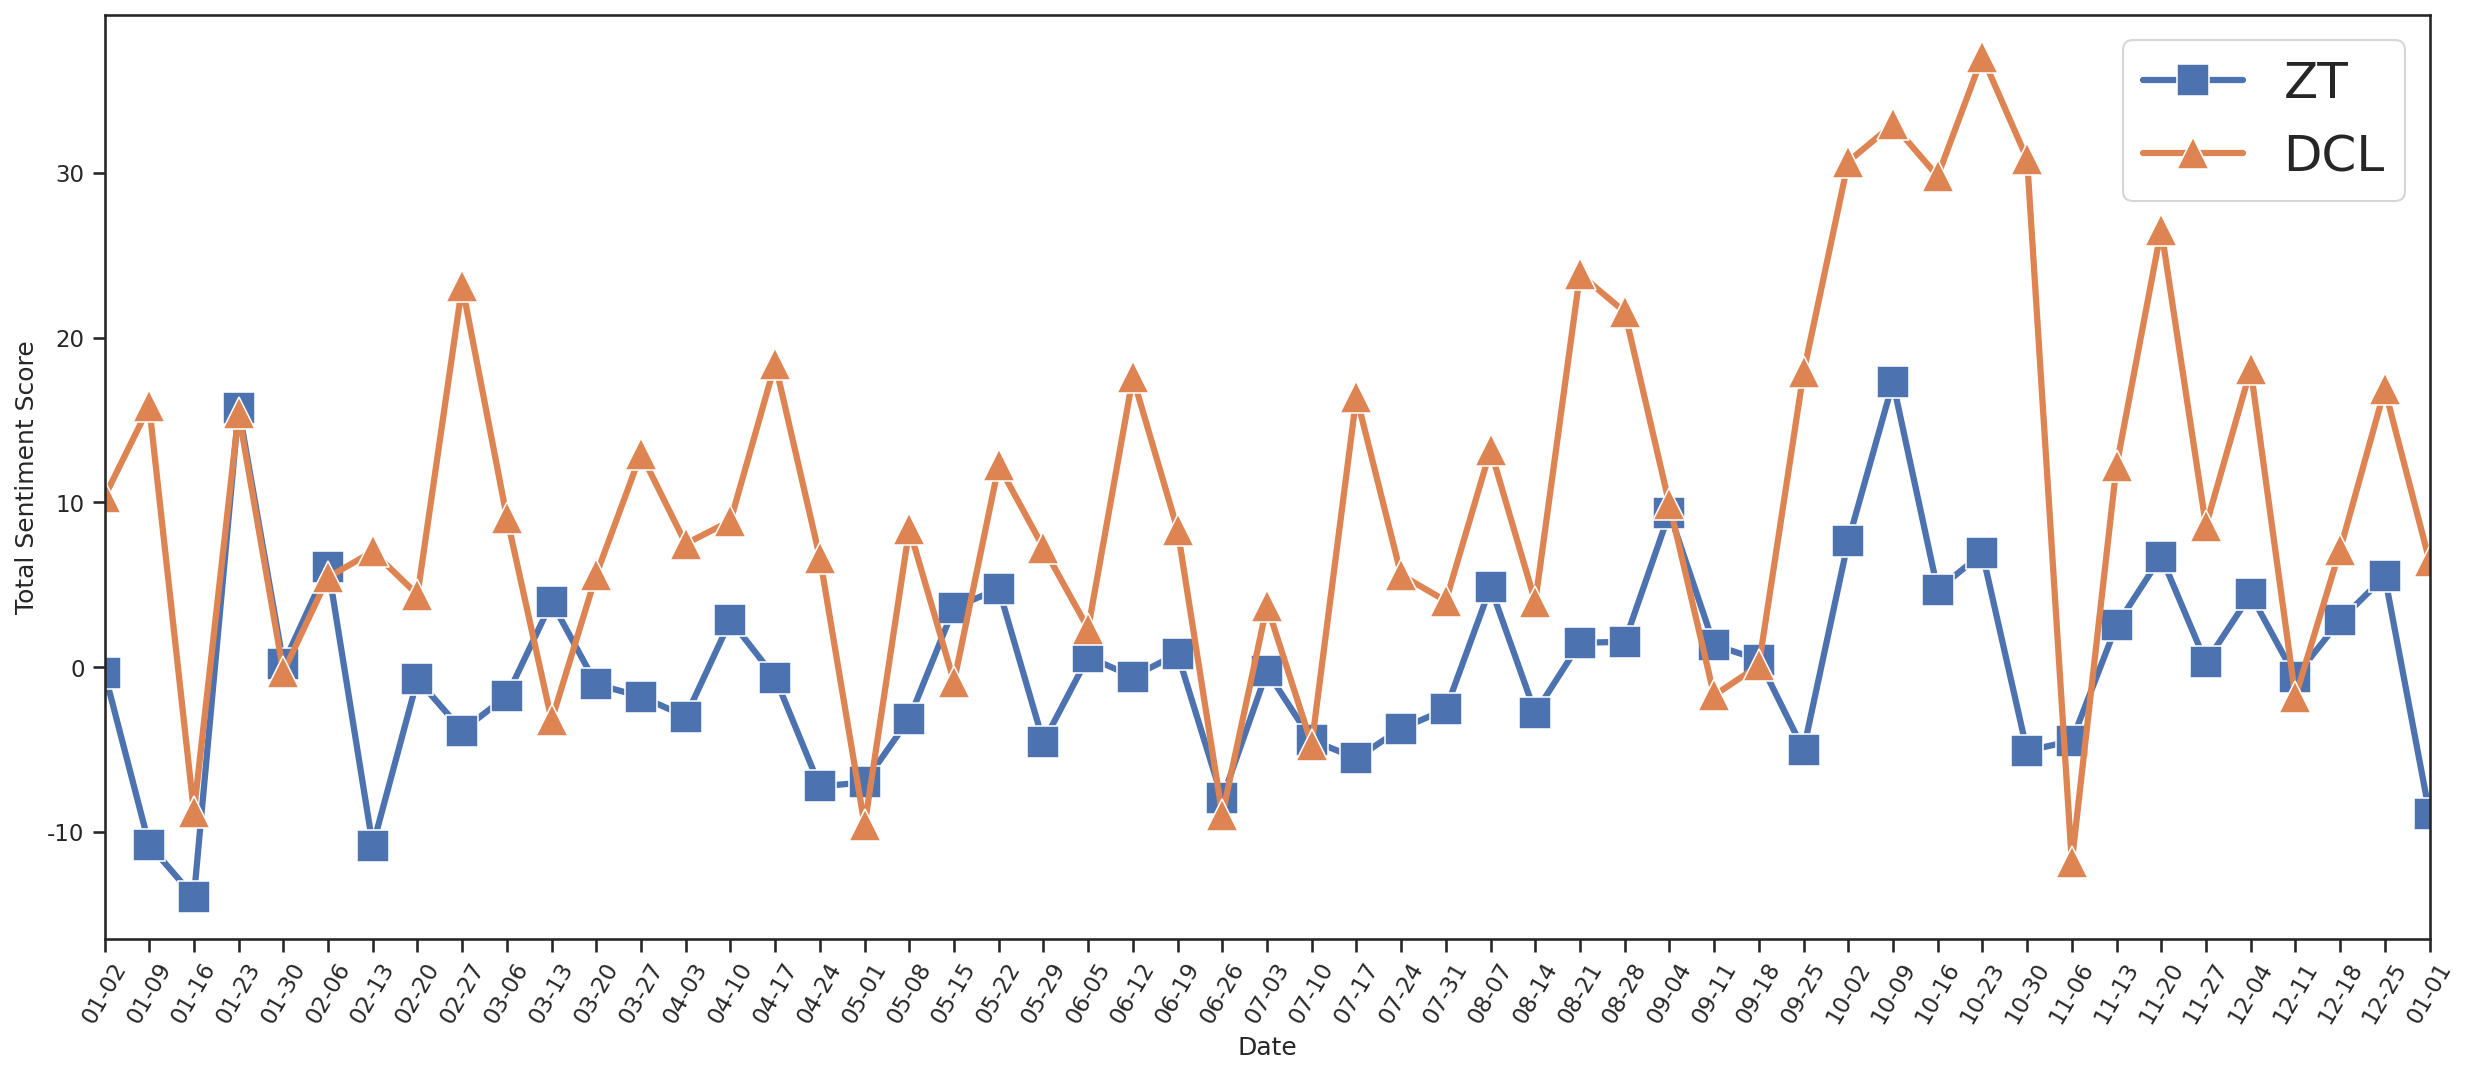

In [240]:
ax = sns.lineplot(data=totSenScore0, linewidth=3, marker="s", markersize=15, label=labels[0])
ax = sns.lineplot(data=totSenScore1, linewidth=3, marker="^", markersize=15, ax=ax, label=labels[1])

ax.set_xlabel("Date")
plt.xticks(rotation=60)
ax.set_ylabel("Total Sentiment Score")
ax.set_xlim(0, 52)
ax.legend(prop={"size": 24})

ax.figure.set_size_inches(20, 8)
ax.figure.set_dpi(150)
plt.show()
plt.close()

### 每日平均情感分析

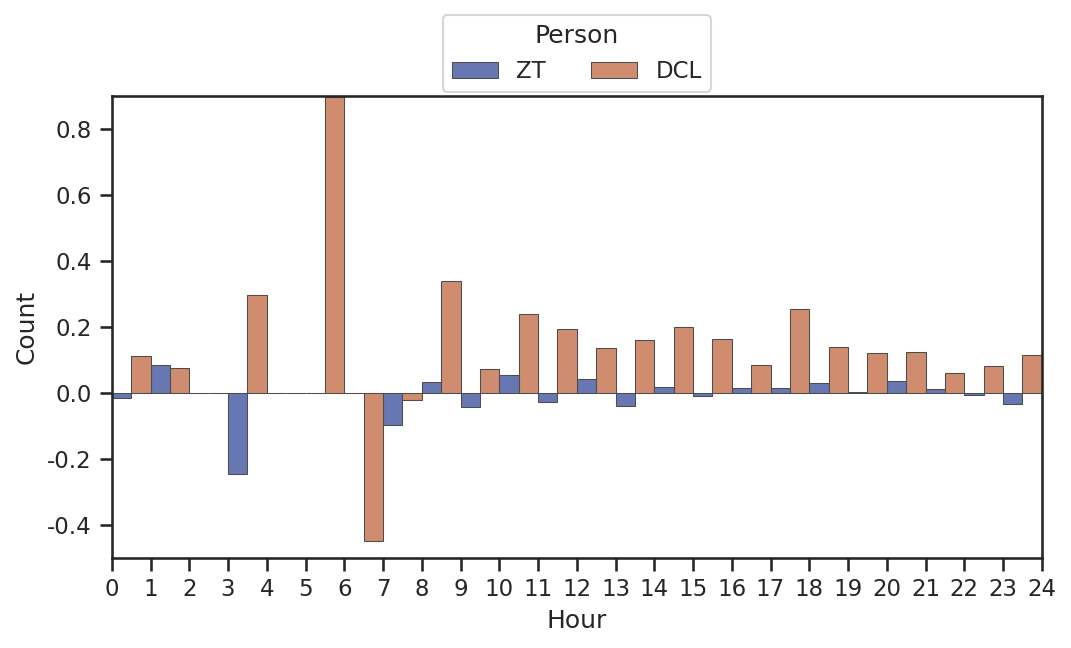

In [244]:
grouper = pd.Grouper(key="hour")

data = []
for k in range(2):
    tmp = dfEs[k].groupby(grouper)["score"].mean().sort_index()
    for i in range(24):
        if i in tmp.index:
            data.append(tmp[i])
        else:
            data.append(0)
    data.append(0)
data = pd.DataFrame(
    {
        "Score": data,
        "Person": [labels[0]] * 25 + [labels[1]] * 25,
    }
)

xBins = [i for i in range(25)]
ax = sns.histplot(
    data=data,
    x=xBins * 2,
    bins=xBins,
    weights="Score",
    hue="Person",
    multiple=multiple,
    edgecolor=".3",
    linewidth=0.5,
    palette="dark",
    alpha=0.6,
)

ax.set_xticks(range(25))
ax.set_xticklabels(range(25))
ax.set_xlabel("Hour")
ax.set_xlim(0, 24)
ax.set_ylim(np.min([0, np.floor(data["Score"].min() / 0.05) * 0.05]), np.ceil(data["Score"].max() / 0.05) * 0.05)
sns.move_legend(ax, loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)

ax.figure.set_size_inches(8, 4)
ax.figure.set_dpi(150)
plt.show()
plt.close()

### 每日累计情感分析

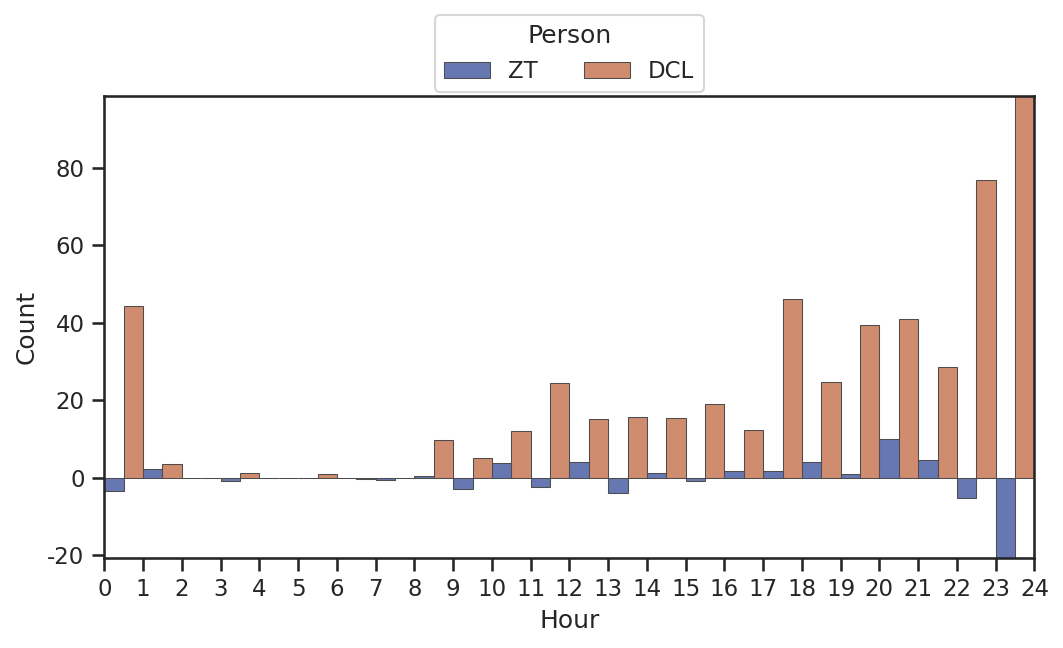

In [243]:
grouper = pd.Grouper(key="hour")

data = []
for k in range(2):
    tmp = dfEs[k].groupby(grouper)["score"].sum().sort_index()
    for i in range(24):
        if i in tmp.index:
            data.append(tmp[i])
        else:
            data.append(0)
    data.append(0)
data = pd.DataFrame(
    {
        "Score": data,
        "Person": [labels[0]] * 25 + [labels[1]] * 25,
    }
)

xBins = [i for i in range(25)]
ax = sns.histplot(
    data=data,
    x=xBins * 2,
    bins=xBins,
    weights="Score",
    hue="Person",
    multiple=multiple,
    edgecolor=".3",
    linewidth=0.5,
    palette="dark",
    alpha=0.6,
)

ax.set_xticks(range(25))
ax.set_xticklabels(range(25))
ax.set_xlabel("Hour")
ax.set_xlim(0, 24)
ax.set_ylim(np.min([0, np.floor(data["Score"].min() / 0.05) * 0.05]), np.ceil(data["Score"].max() / 0.05) * 0.05)
sns.move_legend(ax, loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)

ax.figure.set_size_inches(8, 4)
ax.figure.set_dpi(150)
plt.show()
plt.close()